# <u> Data Bootcamp Final Project <u>

## Data Analysis of NBA Statistics

### Topics Covered:
* #### A look into Undervalued, Underplayed, and Strong Performing Players
* #### Relationships Between Statistics/Correlation with Win Shares
* #### Valuation Model and Evaluating Players
    
### Summary:

The purpose of this project is to analyze different NBA statistics to better understand players' values. I downloaded my data from Basketball Reference and Kaggle at the links below. I filtered my data for 2010 to 2019, eliminated duplicates within each year that came from trades and salary changes, and merged my 2019 data with the current salaries of the NBA players. Additionally, I filtered for different positions, minutes, and salaries to look more closely at the numbers and better compare players.

Throughout the project, I adjusted my dataframes to only include players who played an average of at least 2 minutes per 84 game season. This is because I continuously saw that different players who played minimal minutes had extremely high usage rates and efficiency ratings if they happened to, for example, score a three pointer in 1 minute  played. I believe that this adjustment increases the reliability of my results by eliminating those skewed numbers. In analyzing player performances, I took into account the minutes played and salaries earned by each player to find those who may be undervalued or deserve more minutes. I discovered players who were most efficient with the minutes they were allocated, as well as those who gave the best return on their yearly salary. This information would help GMs and coaches make informed decisions on player personnel and usage.

In order to conduct my valuation, I first examined how different key statistics correlate with win shares. I used this stat because I believe that a player's value should be determined by how he influences his team and delivers them wins. However, strong talent within a team may disperse the win shares among the talented players, driving down each individual's statistic. Therefore, I used the correlation coefficients of key statistics over a 10 year period to determine the values of players, using the numbers to weigh the importance of each stat since win shares alone can be biased. While this is not a perfect fix for the potential dilemma, since other statistics are affected by strength of teammates, it helps diminish the flaw.

Finally, I created a valuation model by using the correlation coefficients and applying them to each player's stats. I multiplied each statistic by its coefficient, added them together, and divided the result by the number of stats used in order to average the win shares estimated for each player. This method proved to be effective, as the model showed 74% accuracy in predicting NBA all-stars over 5 years and identified potentially undervalued players. After discovering each player's value, I weighed the value of players in the top 50% of the league against their yearly salary. This analysis allowed me to discover players whose salaries are most valuable given their return. I also weighed the values against the minutes played to see which players perhaps deserve more time on the court. I repeated these methods, looking into the top performers at each position. I believe my findings would be useful to an NBA GM in deciding which players to target and carrying out different transactions.

While I believe this is a thorough analysis, I am always searching for new perspectives and ideas on how to improve my valuation. If you have any questions, comments, or concerns regarding my analysis, you may reach out to me via email at jeh606@stern.nyu.edu or phone at 610-509-1189. I am excited by any opportunity to enhance this model, so please do not hesitate to contact me if you find anything you believe I can improve.


#### Author: *James Haag*

#### Sources:
    https://www.basketball-reference.com/leagues/NBA_2019_advanced.html
    https://www.basketball-reference.com/leagues/NBA_2019_totals.html
    https://www.basketball-reference.com/contracts/players.html
    https://www.kaggle.com/drgilermo/nba-players-stats#Seasons_Stats.csv

In [1]:
%matplotlib inline 
import pandas as pd
pd.set_option('display.max_columns', 60)
import matplotlib.pyplot as plt
import datetime as dt
import os
import requests, io
import zipfile as zf
import shutil
import numpy as np
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression as reg
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.neighbors import KNeighborsRegressor as knn
plt.style.use('seaborn')
pd.options.display.float_format = '{:,}'.format

In [2]:
# Import the statistics from 1950 through 2019
nbaStats = pd.read_csv('newstats.csv')

# Divide the statistics by year and drop duplicates that came from trades and signings
nbaStats10 = nbaStats.loc[nbaStats['Year'] == 2010]
nbaStats10 = nbaStats10.drop_duplicates(subset = 'Player', keep = 'first')

nbaStats11 = nbaStats.loc[nbaStats['Year'] == 2011]
nbaStats11 = nbaStats11.drop_duplicates(subset = 'Player', keep = 'first')

nbaStats12 = nbaStats.loc[nbaStats['Year'] == 2012]
nbaStats12 = nbaStats12.drop_duplicates(subset = 'Player', keep = 'first')

nbaStats13 = nbaStats.loc[nbaStats['Year'] == 2013]
nbaStats13 = nbaStats13.drop_duplicates(subset = 'Player', keep = 'first')

nbaStats14 = nbaStats.loc[nbaStats['Year'] == 2014]
nbaStats14 = nbaStats14.drop_duplicates(subset = 'Player', keep = 'first')

nbaStats15 = nbaStats.loc[nbaStats['Year'] == 2015]
nbaStats15 = nbaStats15.drop_duplicates(subset = 'Player', keep = 'first')

nbaStats16 = nbaStats.loc[nbaStats['Year'] == 2016]
nbaStats16 = nbaStats16.drop_duplicates(subset = 'Player', keep = 'first')

nbaStats17 = nbaStats.loc[nbaStats['Year'] == 2017]
nbaStats17 = nbaStats17.drop_duplicates(subset = 'Player', keep = 'first')

nbaStats18 = nbaStats.loc[nbaStats['Year'] == 2018]
nbaStats18 = nbaStats18.drop_duplicates(subset = 'Player', keep = 'first')

nbaStats19 = nbaStats.loc[nbaStats['Year'] == 2019]
nbaStats19 = nbaStats19.drop_duplicates(subset = 'Player', keep = 'first')
nbaStats19['USG'] = nbaStats19['USG%']
nbaStats19['eFGpct'] = nbaStats19['eFG%']
nbaStats19['TOVpct'] = nbaStats19['TOV%']
nbaStats19 = nbaStats19.drop(columns = (['Unnamed: 0','ORB%','DRB%','TRB%','AST%','STL%','BLK%',
                                     '2P','2PA','2P%','OWS','DWS','OBPM','DBPM','PF','USG%']))
# Create a dataframe for a ten year span to use when running regressions
nbaStats10yr = (nbaStats10.append(nbaStats11).append(nbaStats12).append(nbaStats13).append(nbaStats14)
                .append(nbaStats15).append(nbaStats16).append(nbaStats17).append(nbaStats18)
                .append(nbaStats19))
# Change title of usage column to avoid complications during regression and drop unused columns
nbaStats10yr['USG'] = nbaStats10yr['USG%']
nbaStats10yr['eFGpct'] = nbaStats10yr['eFG%']
nbaStats10yr['TOVpct'] = nbaStats10yr['TOV%']
nbaStats10yr = nbaStats10yr.drop(columns = (['Unnamed: 0','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%',
                                     '2P','2PA','2P%','OWS','DWS','OBPM','DBPM','PF','USG%']))

# Import salary data for current NBA salaries and drop unused columns
salary = pd.read_excel("NBAcurrentSalaries.xls")
salary.drop(['Rk','Tm', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25', '2025-26', 'Signed Using'], axis=1, inplace=True) # drop unneeded columns
salary['Salary/Year'] = salary['Salary/Year'].round(decimals=0)

# Merge salary data with statistics, matching by Player
nbaStats19 = nbaStats19.merge(salary[['Player','Guaranteed','Salary/Year', 'Years Remaining']],on='Player',how='inner')
nbaStats19 = nbaStats19.drop_duplicates(subset = 'Player', keep = 'first')

# Create datasets for each positon, first including all years, then only including 2019
statsPG = nbaStats.loc[nbaStats['Pos'] == 'PG']
nbaStats19PG = nbaStats19.loc[nbaStats19['Pos'] == 'PG']
statsSG = nbaStats.loc[nbaStats['Pos'] == 'SG']
nbaStats19SG = nbaStats19.loc[nbaStats19['Pos'] == 'SG']
statsSF = nbaStats.loc[nbaStats['Pos'] == 'SF']
nbaStats19SF = nbaStats19.loc[nbaStats19['Pos'] == 'SF']
statsPF = nbaStats.loc[nbaStats['Pos'] == 'PF']
nbaStats19PF = nbaStats19.loc[nbaStats19['Pos'] == 'PF']
statsC = nbaStats.loc[nbaStats['Pos'] == 'C']
nbaStats19C = nbaStats19.loc[nbaStats19['Pos'] == 'C']

## Abbreviation Key:
    Pos: Position
    Tm: Team
    G: Games
    GS: Games Started
    MP: Minutes Played
    PER: Player Efficiency Rating
    TS%: True Shooting %
    3PAr: 3-Point Attempt Rate
    FTr: Free Throw Rate
    ORB%: Offensive Rebound Percentage
    DRB%: Defensive Rebound Percentage
    TRB%: Total Rebound Percentage
    AST%: Assist Percentage
    STL%: Steal Percentage
    BLK%: Block Percentage
    TOV%: Turnover Percentage
    USG%: Usage Percentage
    OWS: Offensive Win Shares
    DWS: Defensive Win Shares
    WS: Win Shares
    WS/48: Win Shares Per 48 Minutes
    OBPM: Offensive Box Plus/Minus
    DBPM: Defensive Box Plus/Minus
    BPM: Box Plus/Minus
    VORP: Value Over Replacement
    FG: Field Goals
    FGA: Field Goal Attempts
    FG%: Field Goal Percentage
    3P: 3-Point Field Goals
    3PA: 3-Point Field Goal Attempts
    3P%: 3-Point Field Goal Percentage
    2P: 2-Point Field Goals
    2PA: 2-Point Field Goal Attempts
    2P%: 2-Point Field Goal Percentage
    eFG%: Effective Field Goal Percentage
    FT: Free Throws
    FTA: Free Throw Attempts
    FT%: Free Throw Percentage
    ORB: Offensive Rebounds
    DRB: Defensive Rebounds
    TRB: Total Rebounds
    AST: Assists
    STL: Steals
    BLK: Blocks
    TOV: Turnovers
    PF: Personal Fouls
    PTS: Points

## Discovery of Special Performers and Undervalued Players
    In this section, I will look at the statistics of players who are not receiving many minutes but are still 
    putting up large numbers, players who are young but effective, players who have low salaries but strong 
    statistics, and players with high BPM, USG%, and PER statistics. I will adjust for players who have high BPM, 
    USG%, and PER due to low minutes played by ensuring all players average at least 2 minutes per game. I will 
    compare players as a whole, as well as by minutes and salary.

### Assists

#### Low Minutes, High Assists

In [3]:
# Identify players who have lower than the median amount of minutes but above the median amount of assists
LowMinHiAST = (nbaStats19.loc[nbaStats19['MP'] < nbaStats19['MP'].median()][nbaStats19['AST'] > nbaStats19['AST'].median()]
               [['Player','Pos','Age','MP','AST','Salary/Year','Years Remaining']])
# Sort and display the dataframe
Top10LowMinHiAST = LowMinHiAST.sort_values('AST', ascending = False).reset_index(drop = True).head(10)
Top10LowMinHiAST

<ipython-input-3-1071ff9bf3fc>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  LowMinHiAST = (nbaStats19.loc[nbaStats19['MP'] < nbaStats19['MP'].median()][nbaStats19['AST'] > nbaStats19['AST'].median()]


,Player,Pos,Age,MP,AST,Salary/Year,Years Remaining
0,Rajon Rondo,PG,32.0,"1,369.0",367.0,"7,500,000.0",2
1,Jeff Teague,PG,30.0,"1,264.0",343.0,"2,564,753.0",1
2,Tyus Jones,PG,22.0,"1,560.0",327.0,"7,743,650.0",2
3,Elfrid Payton,PG,24.0,"1,250.0",320.0,"5,760,000.0",1
4,John Wall,PG,28.0,"1,104.0",279.0,"44,310,840.0",3
5,Kris Dunn,PG,24.0,"1,389.0",277.0,"4,886,175.0",2
6,T.J. McConnell,PG,26.0,"1,470.0",258.0,"3,500,000.0",1
7,Lonzo Ball,PG,21.0,"1,423.0",255.0,"11,003,782.0",1
8,Derrick Rose,PG,30.0,"1,392.0",220.0,"7,682,927.0",1
9,Andre Iguodala,SF,35.0,"1,578.0",216.0,"15,000,000.0",2


**NOTES:** This shows high value players who are potentially underplayed in terms of their production of Assists. *Kris Dunn* and *TJ McConnell* seem to be excellent potential targets, as they are under 27 years old and put up great numbers despite low minutes and low salary. These attributes make them extremely valuable, as they offer a high, long-term reward for a low cost.

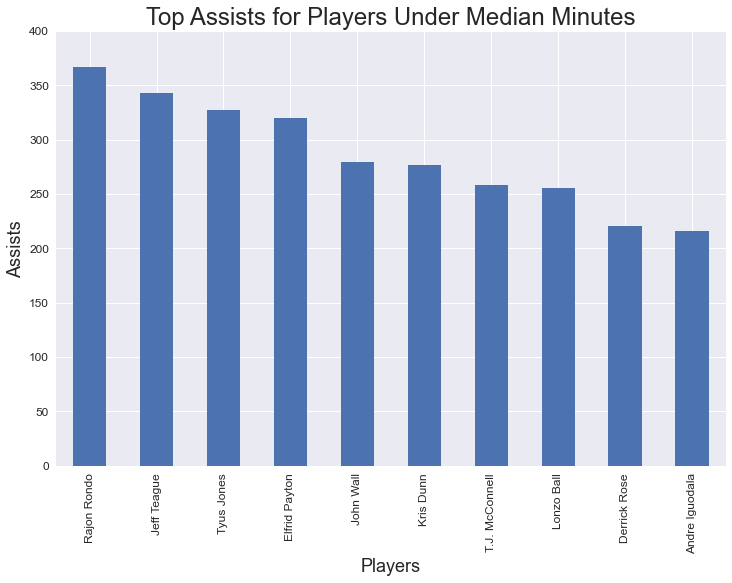

In [4]:
fig,ax = plt.subplots()
Top10LowMinHiAST.plot.bar(x='Player',y='AST',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,400)
ax.set_title('Top Assists for Players Under Median Minutes',size=24)
ax.set_ylabel('Assists',size = 18)
ax.set_xlabel('Players',size = 18)
ax.tick_params(axis='both', which='major', labelsize=12)

#### Low Salary, High Assists

In [5]:
# Identify players with salaries in the lower 50% and discover the top assist amounts of the group
LowSALHiAST = nbaStats19.loc[nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()][['Player','Pos','Age','AST','Salary/Year','Years Remaining']]
# Sort and display the dataframe
Top10LowSALHiAST = LowSALHiAST.sort_values('AST', ascending = False).reset_index(drop = True).head(10)
Top10LowSALHiAST

,Player,Pos,Age,AST,Salary/Year,Years Remaining
0,Marc Gasol,C,34.0,349.0,"2,628,872.0",2
1,Reggie Jackson,PG,28.0,344.0,"2,331,593.0",1
2,Jeff Teague,PG,30.0,343.0,"2,564,753.0",1
3,Elfrid Payton,PG,24.0,320.0,"5,760,000.0",1
4,Kris Dunn,PG,24.0,277.0,"4,886,175.0",2
5,Shai Gilgeous-Alexander,PG,20.0,270.0,"4,818,426.0",2
6,Ryan Arcidiacono,PG,24.0,269.0,"3,000,000.0",2
7,T.J. McConnell,PG,26.0,258.0,"3,500,000.0",1
8,Collin Sexton,PG,20.0,243.0,"5,670,776.0",2
9,Jalen Brunson,PG,22.0,230.0,"1,732,959.0",2


**NOTES:** This shows the assist numbers for low cost players which is extremely valuable to GMs because it provides a high performance for a minimal salary expense. *Ryan Arcidiacono* and *Jalen Brunson* seem to be excellent targets, as they are under 25, and they put up high assist totals while costing under $3 million per year for 2 more seasons.

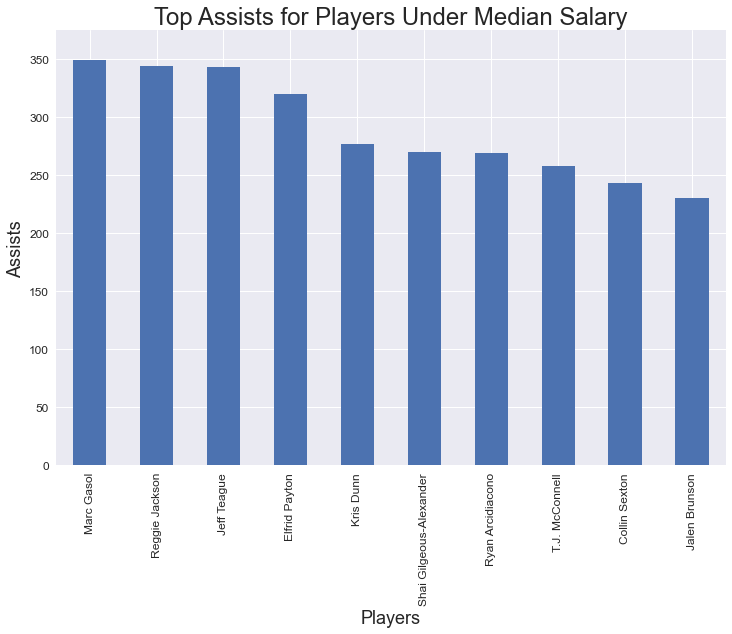

In [6]:
fig,ax = plt.subplots()
Top10LowSALHiAST.plot.bar(x='Player',y='AST',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,375)
ax.set_title('Top Assists for Players Under Median Salary',size=24)
ax.set_ylabel('Assists',size = 18)
ax.set_xlabel('Players',size = 18)
ax.tick_params(axis='both', which='major', labelsize=12)

#### Assists per Minute (Assist Efficiency)

In [7]:
# Discover the assists each player gets per minute played and round to nearest thousanth
nbaStats19['ASTperMP'] = nbaStats19['AST']/nbaStats19['MP']
nbaStats19['ASTperMP'] = nbaStats19['ASTperMP'].round(decimals=3)
# Filter the data to only include players with more than 2 minutes played per game in order for the most accurate results.
ASTperMin = nbaStats19.loc[nbaStats19['MP'] > 164][['Player','Pos','Age','AST','MP','ASTperMP','Salary/Year','Years Remaining']]
# Sort and display the dataframe
Top10ASTperMin = ASTperMin.sort_values('ASTperMP', ascending = False).reset_index(drop = True).head(10)
Top10ASTperMin

,Player,Pos,Age,AST,MP,ASTperMP,Salary/Year,Years Remaining
0,Russell Westbrook,PG,30.0,784.0,"2,630.0",0.298,"44,211,146.0",3
1,J.J. Barea,PG,34.0,211.0,752.0,0.281,"2,564,753.0",1
2,Jeff Teague,PG,30.0,343.0,"1,264.0",0.271,"2,564,753.0",1
3,Rajon Rondo,PG,32.0,367.0,"1,369.0",0.268,"7,500,000.0",2
4,Trae Young,PG,20.0,653.0,"2,503.0",0.261,"7,449,136.0",2
5,Elfrid Payton,PG,24.0,320.0,"1,250.0",0.256,"5,760,000.0",1
6,Kyle Lowry,PG,32.0,564.0,"2,213.0",0.255,"30,000,000.0",1
7,Chris Paul,PG,33.0,473.0,"1,857.0",0.255,"42,784,980.0",2
8,John Wall,PG,28.0,279.0,"1,104.0",0.253,"44,310,840.0",3
9,LeBron James,SF,34.0,454.0,"1,937.0",0.234,"41,625,032.0",3


**NOTES:** *Elfrid Payton* appears to be of high value, as he is in the top ten for Assists per minute, costs under $6 million, and is 24 years old. It seems he is deserving of more minutes, as he has shown his efficiency during his time on the court.

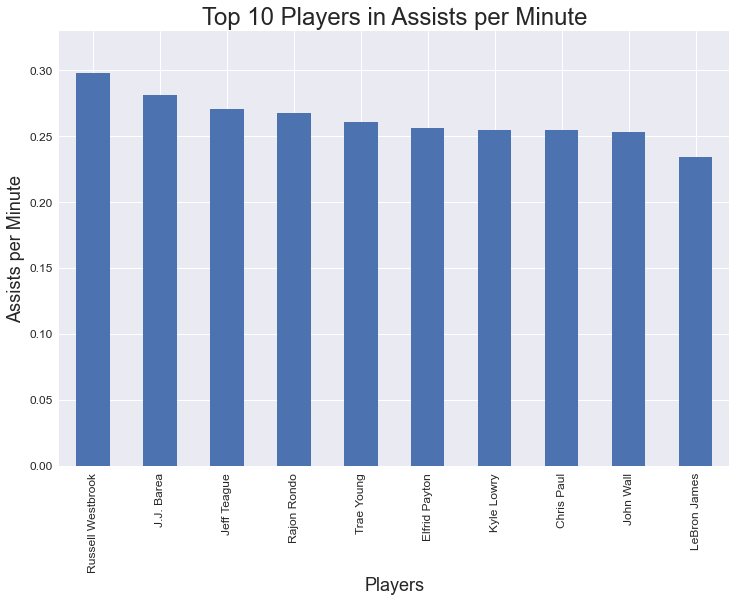

In [8]:
fig,ax = plt.subplots()
Top10ASTperMin.plot.bar(x='Player',y='ASTperMP',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,0.33)
ax.set_title('Top 10 Players in Assists per Minute',size=24)
ax.set_ylabel('Assists per Minute',size = 18)
ax.set_xlabel('Players',size = 18)
ax.tick_params(axis='both', which='major', labelsize=12)

#### Low Salary, High Assists Per Minute

In [9]:
# Filter data to only include players with more than 2 minutes played per game in order for the most accuracy
# Filter data to only include players with salary below the median
ASTperMin2= (nbaStats19.loc[nbaStats19['MP'] > 164][nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()]
             [['Player','Pos','Age','AST','MP','ASTperMP','Salary/Year','Years Remaining']])
# Sort and display dataframe
Top10ASTperMin2 = ASTperMin2.sort_values('ASTperMP', ascending = False).reset_index(drop = True).head(10)
Top10ASTperMin2

<ipython-input-9-5f0ed8ad5a6e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ASTperMin2= (nbaStats19.loc[nbaStats19['MP'] > 164][nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()]


,Player,Pos,Age,AST,MP,ASTperMP,Salary/Year,Years Remaining
0,J.J. Barea,PG,34.0,211.0,752.0,0.281,"2,564,753.0",1
1,Jeff Teague,PG,30.0,343.0,"1,264.0",0.271,"2,564,753.0",1
2,Elfrid Payton,PG,24.0,320.0,"1,250.0",0.256,"5,760,000.0",1
3,Matthew Dellavedova,PG,28.0,181.0,812.0,0.223,"2,174,318.0",1
4,Kris Dunn,PG,24.0,277.0,"1,389.0",0.199,"4,886,175.0",2
5,Raul Neto,PG,26.0,93.0,474.0,0.196,"1,882,867.0",1
6,Michael Carter-Williams,PG,27.0,70.0,372.0,0.188,"3,000,000.0",2
7,Devonte' Graham,PG,23.0,121.0,676.0,0.179,"1,663,861.0",1
8,T.J. McConnell,PG,26.0,258.0,"1,470.0",0.176,"3,500,000.0",1
9,Jerian Grant,PG,26.0,156.0,939.0,0.166,"1,882,867.0",1


**NOTES:** This shows the players who cost less than the median salary who provide the most efficiency in dishing out assists. *Raul Neto, Devonte Graham,* and *Jerian Grant* seem to be very valuable, as they cost less than $2 million per year, are 26 years old or younger, and put up high assist numbers for eacn minute played.

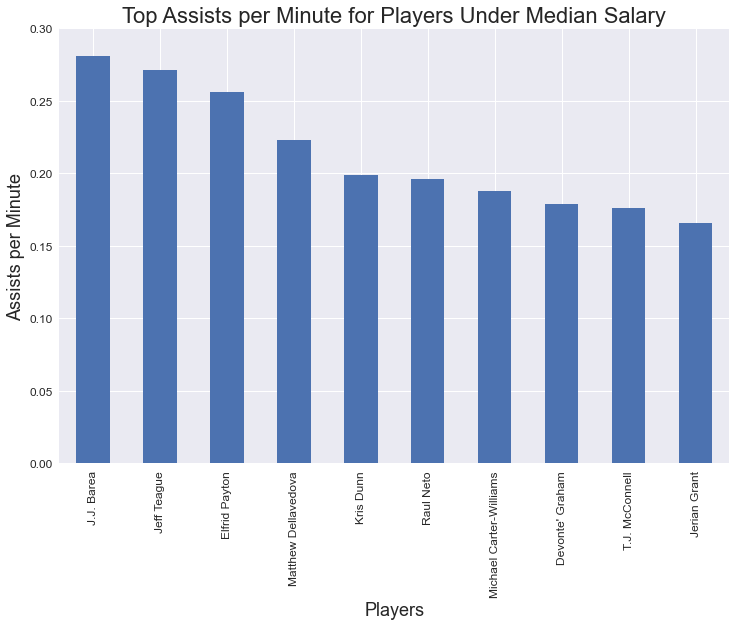

In [10]:
fig,ax = plt.subplots()
Top10ASTperMin2.plot.bar(x='Player',y='ASTperMP',ax=ax,figsize=(12,8),legend = False)
ax.set_ylim(0,.3)
ax.set_title('Top Assists per Minute for Players Under Median Salary',size=22)
ax.set_ylabel('Assists per Minute',size = 18)
ax.set_xlabel('Players',size = 18)
ax.tick_params(axis='both', which='major', labelsize=12)

### Points

#### Low Minutes, High Points

In [11]:
# Identify players who have below the median minutes played, but managed to put up high point totals
LowMinHiPTS = (nbaStats19.loc[nbaStats19['MP'] < nbaStats19['MP'].median()]
               [['Player','Pos','Age','PTS','MP','Salary/Year','Years Remaining']])
# Sort and display the dataframe
Top10LowMinHiPTS = LowMinHiPTS.sort_values('PTS', ascending = False).reset_index(drop = True).head(10)
Top10LowMinHiPTS

,Player,Pos,Age,PTS,MP,Salary/Year,Years Remaining
0,Derrick Rose,PG,30.0,917.0,"1,392.0","7,682,927.0",1
1,Alex Len,C,25.0,854.0,"1,544.0","2,320,000.0",1
2,T.J. Warren,SF,25.0,772.0,"1,360.0","12,220,000.0",2
3,Jonas Valančiūnas,C,26.0,763.0,"1,091.0","14,500,000.0",2
4,Thomas Bryant,C,21.0,758.0,"1,496.0","8,531,746.0",2
5,Bobby Portis,PF,23.0,710.0,"1,299.0","3,713,575.0",2
6,Victor Oladipo,SG,26.0,675.0,"1,147.0","21,000,000.0",1
7,John Wall,PG,28.0,663.0,"1,104.0","44,310,840.0",3
8,Malik Monk,SG,20.0,653.0,"1,258.0","5,345,687.0",1
9,E'Twaun Moore,SG,29.0,633.0,"1,463.0","2,331,593.0",1


**NOTES:** This shows the players who receive less than the median minutes played who produce the most points. *Alex Len* and *Bobby Portis* seem to be undervalued players, as they score a large amount of points despite low minutes and cost under $4 million. They are also 25 years old and younger, providing good value for the future.

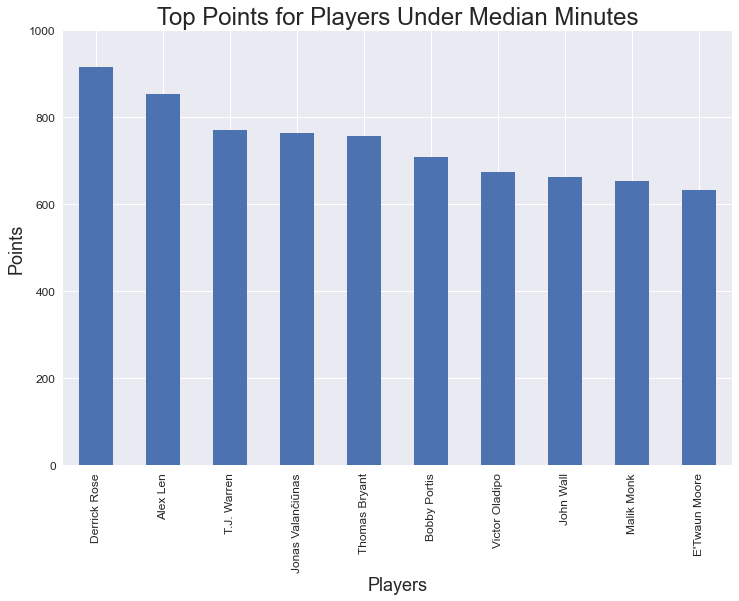

In [12]:
fig,ax = plt.subplots()
Top10LowMinHiPTS.plot.bar(x='Player',y='PTS',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,1000)
ax.set_title('Top Points for Players Under Median Minutes',size=24)
ax.set_ylabel('Points',size = 18)
ax.set_xlabel('Players',size = 18)
ax.tick_params(axis='both', which='major', labelsize=12)

#### Low Salary, High Points

In [13]:
# Identify players with salaries in the lower 50% and discover the top point totals of the group
LowSALHiPTS = nbaStats19.loc[nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()][['Player','Pos','Age','PTS','Salary/Year','Years Remaining']]
# Sort and display the dataframe
Top10LowSALHiPTS = LowSALHiPTS.sort_values('PTS', ascending = False).reset_index(drop = True).head(10)
Top10LowSALHiPTS

,Player,Pos,Age,PTS,Salary/Year,Years Remaining
0,Collin Sexton,PG,20.0,"1,371.0","5,670,776.0",2
1,Reggie Jackson,PG,28.0,"1,260.0","2,331,593.0",1
2,John Collins,PF,21.0,"1,188.0","4,137,302.0",1
3,Marc Gasol,C,34.0,"1,071.0","2,628,872.0",2
4,Lauri Markkanen,PF,21.0,974.0,"6,731,508.0",1
5,Bryn Forbes,SG,25.0,967.0,"2,395,574.0",2
6,Willie Cauley-Stein,C,25.0,965.0,"4,100,000.0",2
7,Kevin Knox,PF,19.0,963.0,"5,217,329.0",2
8,Jeff Green,PF,32.0,946.0,"2,564,753.0",1
9,Jabari Parker,PF,23.0,930.0,"6,500,000.0",1


**NOTES:**  Bryn Forbes and Willie Cauley-Stein are good targets, as they score a lot of points while costing under $4.5 million per year and are 25 years old. Additionally, they have 2 more years on their contract, so their cost is not at risk to go up for a couple years.

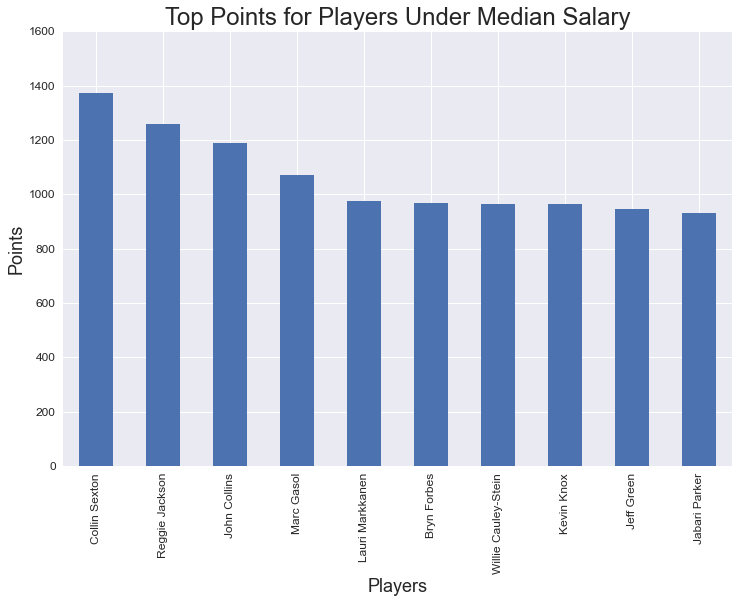

In [14]:
fig,ax = plt.subplots()
Top10LowSALHiPTS.plot.bar(x='Player',y='PTS',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,1600)
ax.set_title('Top Points for Players Under Median Salary',size=24)
ax.set_ylabel('Points',size = 18)
ax.set_xlabel('Players',size = 18)
ax.tick_params(axis='both', which='major', labelsize=12)

#### Points per Minute (Scoring Efficiency)

In [15]:
# Identify the number of points scored per minute played and round it to thousanths
nbaStats19['PTSperMP'] = nbaStats19['PTS']/nbaStats19['MP']
nbaStats19['PTSperMP'] = nbaStats19['PTSperMP'].round(decimals=3)
# Filter data to only include players with more than 2 minutes played per game in order for the most accuracy.
PTSperMin= nbaStats19.loc[nbaStats19['MP'] > 164][['Player','Pos','Age','PTS','MP','PTSperMP','Salary/Year','Years Remaining']]
#Sort and displaying the dataframe
Top10PTSperMin = PTSperMin.sort_values('PTSperMP', ascending = False).reset_index(drop = True).head(10)
Top10PTSperMin

,Player,Pos,Age,PTS,MP,PTSperMP,Salary/Year,Years Remaining
0,James Harden,PG,29.0,"2,818.0","2,867.0",0.983,"43,848,000.0",3
1,Giannis Antetokounmpo,PF,24.0,"1,994.0","2,358.0",0.846,"42,621,486.0",6
2,Joel Embiid,C,24.0,"1,761.0","2,154.0",0.818,"31,579,390.0",3
3,Stephen Curry,PG,30.0,"1,881.0","2,331.0",0.807,"44,393,664.0",2
4,Anthony Davis,C,25.0,"1,452.0","1,850.0",0.785,"37,980,720.0",5
5,Kawhi Leonard,SF,27.0,"1,596.0","2,040.0",0.782,"35,197,650.0",2
6,LeBron James,SF,34.0,"1,505.0","1,937.0",0.777,"41,625,032.0",3
7,Paul George,SF,28.0,"2,159.0","2,841.0",0.76,"42,343,176.0",5
8,Devin Booker,SG,22.0,"1,700.0","2,242.0",0.758,"32,700,000.0",4
9,Lou Williams,SG,32.0,"1,498.0","1,993.0",0.752,"8,000,000.0",1


**NOTES:** This shows the players who score most efficiently. Not surprisingly, James Harden leads the league in this category, scoring about 1 point each minute played. Lou Williams is only $8 million and is an efficient scorer, but his age may turn GMs away. Nonetheless, he is a good target for a short term role player.

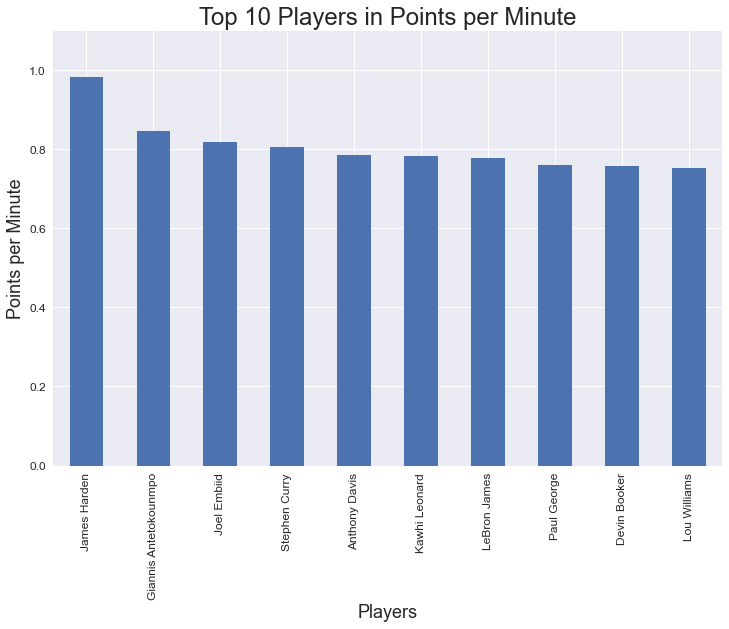

In [16]:
fig,ax = plt.subplots()
Top10PTSperMin.plot.bar(x='Player',y='PTSperMP',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,1.1)
ax.set_title('Top 10 Players in Points per Minute',size=24)
ax.set_ylabel('Points per Minute',size = 18)
ax.set_xlabel('Players',size = 18)
ax.tick_params(axis='both', which='major', labelsize=12)

#### Low Salary, High Points per Minute

In [17]:
# Identify the points per minute played for those below the median salary
# Filter data to only include players with more than 2 minutes played per game in order for the most accuracy.
PTSperMin2= (nbaStats19.loc[nbaStats19['MP'] > 164][nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()]
             [['Player','Pos','Age','PTS','MP','PTSperMP','Salary/Year','Years Remaining']])
# Sort and display the dataframe
Top10PTSperMin2 = PTSperMin2.sort_values('PTSperMP', ascending = False).reset_index(drop = True).head(10)
Top10PTSperMin2

<ipython-input-17-dde186f19891>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PTSperMin2= (nbaStats19.loc[nbaStats19['MP'] > 164][nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()]


,Player,Pos,Age,PTS,MP,PTSperMP,Salary/Year,Years Remaining
0,John Collins,PF,21.0,"1,188.0","1,829.0",0.65,"4,137,302.0",1
1,DeMarcus Cousins,C,28.0,488.0,771.0,0.633,"2,331,593.0",1
2,Boban Marjanović,C,30.0,422.0,681.0,0.62,"3,500,000.0",1
3,Lauri Markkanen,PF,21.0,974.0,"1,682.0",0.579,"6,731,508.0",1
4,Trey Burke,PG,26.0,631.0,"1,125.0",0.561,"3,333,333.0",3
5,Enes Kanter,C,26.0,915.0,"1,640.0",0.558,"5,005,350.0",1
6,Alex Len,C,25.0,854.0,"1,544.0",0.553,"2,320,000.0",1
7,J.J. Barea,PG,34.0,415.0,752.0,0.552,"2,564,753.0",1
8,Reggie Jackson,PG,28.0,"1,260.0","2,289.0",0.55,"2,331,593.0",1
9,Bobby Portis,PF,23.0,710.0,"1,299.0",0.547,"3,713,575.0",2


**NOTES:** *Trey Burke* and *Bobby Portis* average over half a point per minute and cost under $4 million for at least 2 more years. This signals that they could be excellent targets if a team is looking for a productive player for a low cost. Their young age also provides a positive future upside as well.

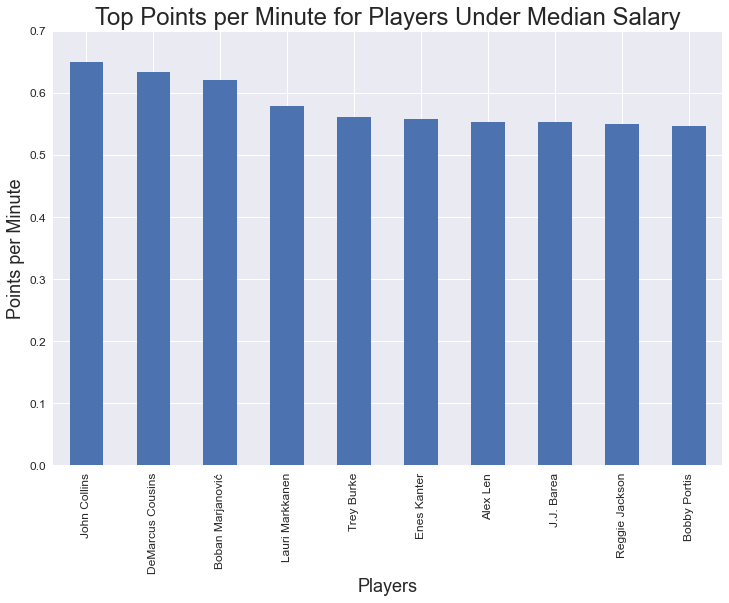

In [18]:
fig,ax = plt.subplots()
Top10PTSperMin2.plot.bar(x='Player',y='PTSperMP',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,.7)
ax.set_title('Top Points per Minute for Players Under Median Salary',size=24)
ax.set_ylabel('Points per Minute',size = 18)
ax.set_xlabel('Players',size = 18)
ax.tick_params(axis='both', which='major', labelsize=12)

### Rebounds

#### Low Minutes, High Rebounds

In [19]:
# Identify players who play fewer minutes than the median
LowMinHiTRB = (nbaStats19.loc[nbaStats19['MP'] < nbaStats19['MP'].median()]
               [['Player','Pos','Age','Tm','TRB','MP','Salary/Year','Years Remaining']])
# Sort and display the dataframe
Top10LowMinHiTRB = LowMinHiTRB.sort_values('TRB', ascending = False).reset_index(drop = True).head(10)
Top10LowMinHiTRB

,Player,Pos,Age,Tm,TRB,MP,Salary/Year,Years Remaining
0,Ed Davis,C,29.0,BRK,694.0,"1,446.0","5,005,350.0",1
1,Thomas Bryant,C,21.0,WAS,454.0,"1,496.0","8,531,746.0",2
2,Tristan Thompson,C,27.0,CLE,438.0,"1,198.0","9,489,450.0",2
3,Alex Len,C,25.0,ATL,424.0,"1,544.0","2,320,000.0",1
4,Mitchell Robinson,C,20.0,NYK,423.0,"1,360.0","1,732,959.0",2
5,Jonas Valančiūnas,C,26.0,TOT,419.0,"1,091.0","14,500,000.0",2
6,Kevon Looney,C,22.0,GSW,417.0,"1,481.0","5,000,000.0",2
7,JaMychal Green,PF,28.0,TOT,409.0,"1,371.0","7,379,754.0",2
8,Bobby Portis,PF,23.0,TOT,403.0,"1,299.0","3,713,575.0",2
9,Ivica Zubac,C,21.0,TOT,362.0,"1,040.0","7,345,679.0",3


**NOTES:** *Bobby Portis, Mitchell Robinson,* and *Kevon Looney* seem to be undervalued and underplayed, as they put up high rebounding numbers despite few minutes and low salaries. Additionally, they are all under 24 years old, adding to their value by promising a potential future return.

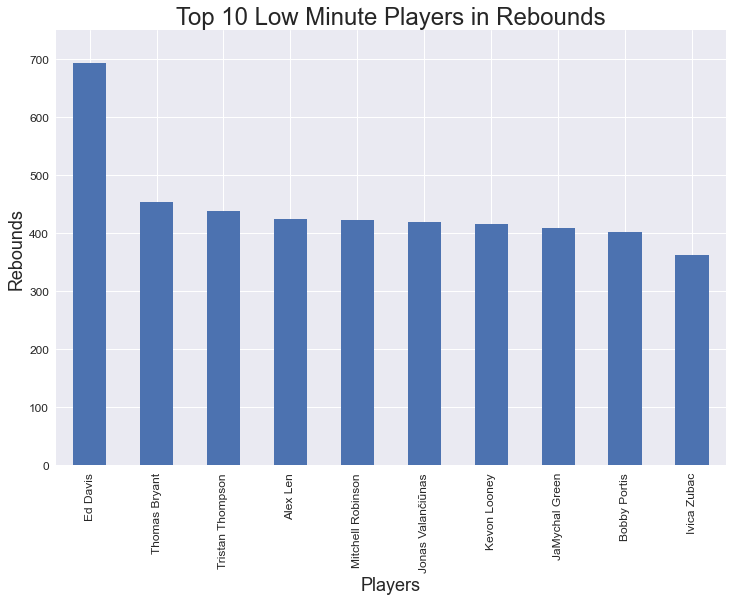

In [20]:
fig,ax = plt.subplots()
Top10LowMinHiTRB.plot.bar(x='Player',y='TRB',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,750)
ax.set_title('Top 10 Low Minute Players in Rebounds',size=24)
ax.set_ylabel('Rebounds',size = 18)
ax.set_xlabel('Players',size = 18)
ax.tick_params(axis='both', which='major', labelsize=12)

#### Low Salary, High Rebounds

In [21]:
# Identify the rebounds total for players for those with salaries below the median
LowSALHiTRB = nbaStats19.loc[nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()][['Player','Pos','Age','TRB','Salary/Year','Years Remaining']]
# Sort and display the dataframe
Top10LowSALHiTRB = LowSALHiTRB.sort_values('TRB', ascending = False).reset_index(drop = True).head(10)
Top10LowSALHiTRB

,Player,Pos,Age,TRB,Salary/Year,Years Remaining
0,Hassan Whiteside,C,29.0,817.0,"2,320,044.0",1
1,Ed Davis,C,29.0,694.0,"5,005,350.0",1
2,Willie Cauley-Stein,C,25.0,678.0,"4,100,000.0",2
3,Jarrett Allen,C,20.0,672.0,"3,909,902.0",1
4,Enes Kanter,C,26.0,659.0,"5,005,350.0",1
5,Marc Gasol,C,34.0,627.0,"2,628,872.0",2
6,John Collins,PF,21.0,595.0,"4,137,302.0",1
7,JaVale McGee,C,31.0,566.0,"4,200,000.0",1
8,Dewayne Dedmon,C,29.0,480.0,"2,866,667.0",5
9,Lauri Markkanen,PF,21.0,470.0,"6,731,508.0",1


**NOTES:** *Hassan Whiteside* soars above all others in this category, showing how valuable he is despite his age and a salary under 2.5 million dollars. *Jarrett Allen* is also extremely valuable, as he is 20 years old, a top performer, and costs under 4 million dollars. Additionally, *Willie Cauley-Stein* also is highly valuable given 2 years remaining on his contract at 4.1 million dollars and his excellent performance.

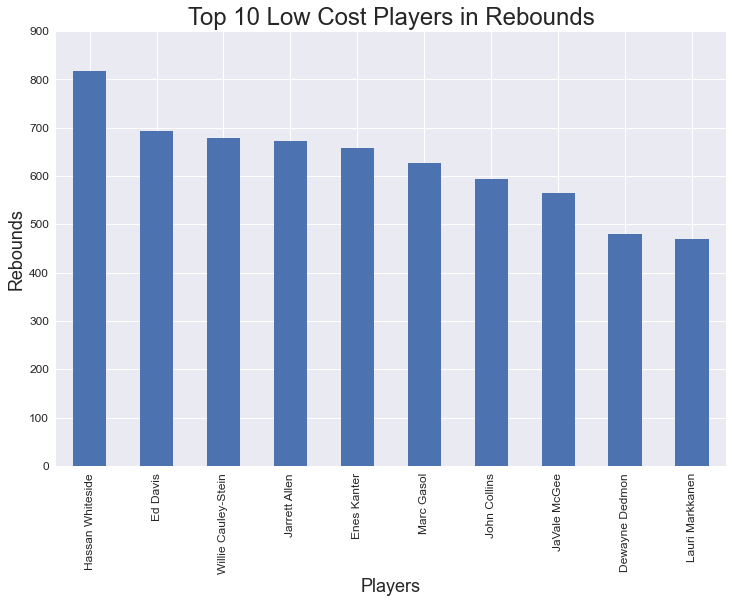

In [22]:
fig,ax = plt.subplots()
Top10LowSALHiTRB.plot.bar(x='Player',y='TRB',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,900)
ax.set_title('Top 10 Low Cost Players in Rebounds',size=24)
ax.set_ylabel('Rebounds',size = 18)
ax.set_xlabel('Players',size = 18)
ax.tick_params(axis='both', which='major', labelsize=12)

#### Rebounds per Minute (Rebounding Efficiency)

In [23]:
# Discover the rebounds per minute played and rounding to nearest thousanth
nbaStats19['TRBperMP'] = nbaStats19['TRB']/nbaStats19['MP']
nbaStats19['TRBperMP'] = nbaStats19['TRBperMP'].round(decimals=3)
# Filter data to only include players with more than 2 minutes played per game in order for the most accuracy.
TRBperMin= nbaStats19.loc[nbaStats19['MP'] > 164][['Player','Pos','Age','Tm','TRB','MP','TRBperMP','Salary/Year','Years Remaining']]
# Sort and display the dataframe
Top10TRBperMin = TRBperMin.sort_values('TRBperMP', ascending = False).reset_index(drop = True).head(10)
Top10TRBperMin

,Player,Pos,Age,Tm,TRB,MP,TRBperMP,Salary/Year,Years Remaining
0,Hassan Whiteside,C,29.0,MIA,817.0,"1,674.0",0.488,"2,320,044.0",1
1,Ed Davis,C,29.0,BRK,694.0,"1,446.0",0.48,"5,005,350.0",1
2,Andre Drummond,C,25.0,DET,"1,232.0","2,647.0",0.465,"28,751,775.0",1
3,DeAndre Jordan,C,30.0,TOT,902.0,"2,047.0",0.441,"10,026,373.0",3
4,Joel Embiid,C,24.0,PHI,871.0,"2,154.0",0.404,"31,579,390.0",3
5,Rudy Gobert,C,26.0,UTA,"1,041.0","2,577.0",0.404,"38,587,547.0",6
6,Enes Kanter,C,26.0,TOT,659.0,"1,640.0",0.402,"5,005,350.0",1
7,Kevin Love,PF,30.0,CLE,239.0,598.0,0.4,"30,500,000.0",3
8,Boban Marjanović,C,30.0,TOT,265.0,681.0,0.389,"3,500,000.0",1
9,Jonas Valančiūnas,C,26.0,TOT,419.0,"1,091.0",0.384,"14,500,000.0",2


**NOTES:** *Enes Kanter* and *Ed Davis* seem to be extremely undervalued, as they are top 10 in rebounds per minute but cost under 5.1 million dollars and played under 700 minutes. Again, *Hassan Whiteside* provides incredible value in the rebounding category, as he leads in rebounding efficiency and is only 2.32 million dollars. These players could be valuable additions to an NBA roster.

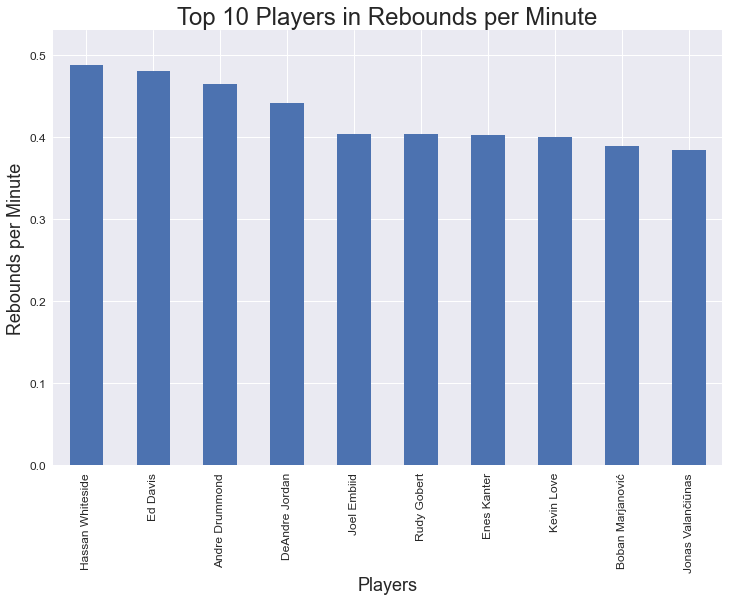

In [24]:
fig,ax = plt.subplots()
Top10TRBperMin.plot.bar(x='Player',y='TRBperMP',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,0.53)
ax.set_title('Top 10 Players in Rebounds per Minute',size=24)
ax.set_ylabel('Rebounds per Minute',size = 18)
ax.set_xlabel('Players',size = 18)
ax.tick_params(axis='both', which='major', labelsize=12)

#### Low Salary, High Rebounds per Minute

In [25]:
# Discover the rebounds per minute played and round to nearest thousanth
nbaStats19['TRBperMP'] = nbaStats19['TRB']/nbaStats19['MP']
nbaStats19['TRBperMP'] = nbaStats19['TRBperMP'].round(decimals=3)
# Filter data to only include players with more than 2 minutes played per game in order for the most accuracy.
# Filter data to only include players with salaries below the median
TRBperMin2= (nbaStats19.loc[nbaStats19['MP'] > 164][nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()]
             [['Player','Pos','Age','PTS','MP','TRBperMP','Salary/Year','Years Remaining']])
# Sort and display the dataframe
Top10TRBperMin2 = TRBperMin2.sort_values('TRBperMP', ascending = False).reset_index(drop = True).head(10)
Top10TRBperMin2

<ipython-input-25-4ebc645f4e81>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TRBperMin2= (nbaStats19.loc[nbaStats19['MP'] > 164][nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()]


,Player,Pos,Age,PTS,MP,TRBperMP,Salary/Year,Years Remaining
0,Hassan Whiteside,C,29.0,887.0,"1,674.0",0.488,"2,320,044.0",1
1,Ed Davis,C,29.0,472.0,"1,446.0",0.48,"5,005,350.0",1
2,Enes Kanter,C,26.0,915.0,"1,640.0",0.402,"5,005,350.0",1
3,Boban Marjanović,C,30.0,422.0,681.0,0.389,"3,500,000.0",1
4,Willy Hernangómez,C,24.0,421.0,812.0,0.383,"1,727,145.0",1
5,Dwight Howard,C,33.0,115.0,230.0,0.361,"2,564,753.0",1
6,Joakim Noah,C,33.0,298.0,693.0,0.343,"6,431,666.0",2
7,JaVale McGee,C,31.0,897.0,"1,671.0",0.339,"4,200,000.0",1
8,John Collins,PF,21.0,"1,188.0","1,829.0",0.325,"4,137,302.0",1
9,Jarrett Allen,C,20.0,873.0,"2,096.0",0.321,"3,909,902.0",1


**NOTES:** This chart shows very high value players, as they are able to put up impressive numbers while all costing less than $6.5 million. Teams should target these players to boost their rebounding numbers without spending much money and creating a long term value with young players.

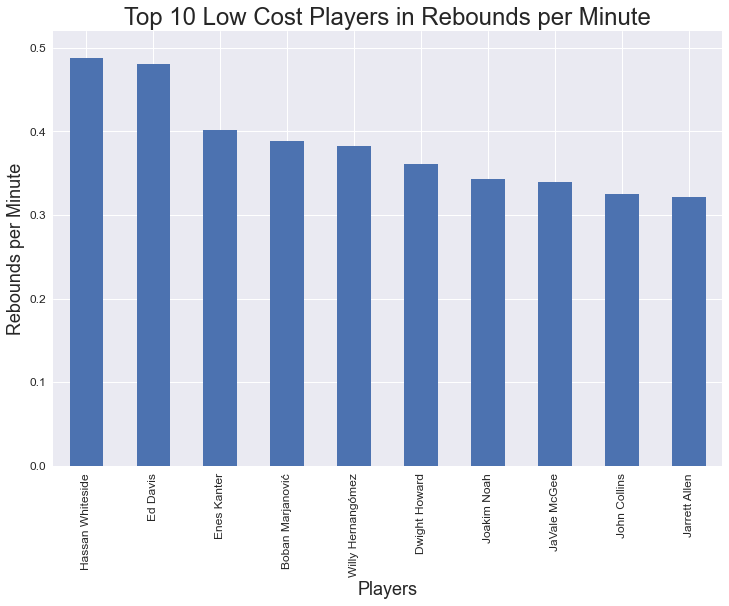

In [26]:
fig,ax = plt.subplots()
Top10TRBperMin2.plot.bar(x='Player',y='TRBperMP',ax=ax,figsize=(12,8),legend = False)
ax.set_ylim(0,0.52)
ax.set_title('Top 10 Low Cost Players in Rebounds per Minute',size=24)
ax.set_ylabel('Rebounds per Minute',size = 18)
ax.set_xlabel('Players',size = 18)
ax.tick_params(axis='both', which='major', labelsize=12)

### Usage %

#### Low Minutes, High USG%

In [27]:
# Discover USG% for players who play under the median number of minutes
# Adjust for players who barely played and saw high usage rate as a result
LowMinHiUSG = (nbaStats19.loc[nbaStats19['MP'] < nbaStats19['MP'].median()][nbaStats19['MP'] > 164]
               [nbaStats19['USG'] > nbaStats19['USG'].median()][['Player','Pos','Age','Tm','USG','MP','Salary/Year','Years Remaining']])
# Sort and display the dataframe
Top10LowMinHiUSG = LowMinHiUSG.sort_values('USG', ascending = False).reset_index(drop = True).head(10)
Top10LowMinHiUSG

<ipython-input-27-13ef7134c89a>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  LowMinHiUSG = (nbaStats19.loc[nbaStats19['MP'] < nbaStats19['MP'].median()][nbaStats19['MP'] > 164]


,Player,Pos,Age,Tm,USG,MP,Salary/Year,Years Remaining
0,John Wall,PG,28.0,WAS,28.8,"1,104.0","44,310,840.0",3
1,Jonas Valančiūnas,C,26.0,TOT,28.5,"1,091.0","14,500,000.0",2
2,J.J. Barea,PG,34.0,DAL,28.1,752.0,"2,564,753.0",1
3,DeMarcus Cousins,C,28.0,GSW,28.1,771.0,"2,331,593.0",1
4,Victor Oladipo,SG,26.0,IND,27.9,"1,147.0","21,000,000.0",1
5,Kevin Love,PF,30.0,CLE,27.4,598.0,"30,500,000.0",3
6,Derrick Rose,PG,30.0,MIN,27.3,"1,392.0","7,682,927.0",1
7,Christian Wood,PF,23.0,TOT,26.1,251.0,"13,666,667.0",3
8,Trey Burke,PG,26.0,TOT,24.8,"1,125.0","3,333,333.0",3
9,Malik Monk,SG,20.0,CHO,24.6,"1,258.0","5,345,687.0",1


**NOTES:** This chart shows the players who played fewer minutes than 50% of the league who were used the most by their respective teams while on the court, suggesting that they may deserve more minutes. John Wall and Victor Oladipo made this list, but only due to injury. Trey Burke is an excellent target, as he is 26 years old, costs under $3.4 million while holding a usage rate of 24.8%.

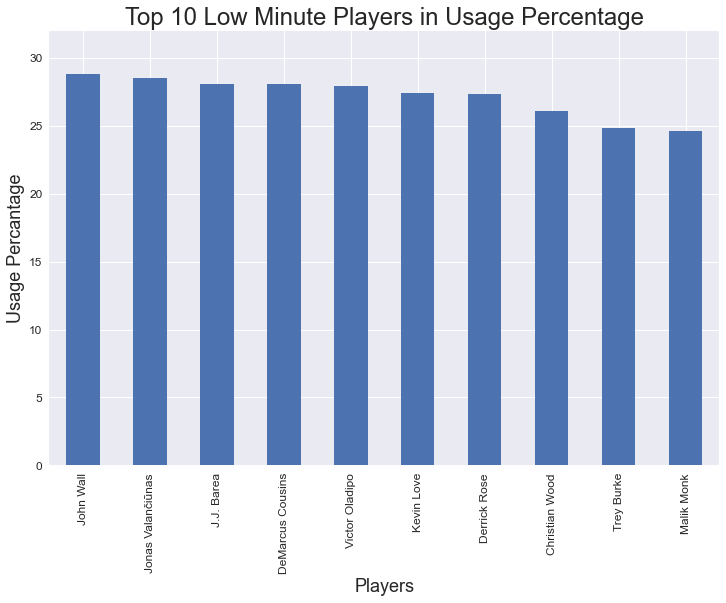

In [28]:
fig,ax = plt.subplots()
Top10LowMinHiUSG.plot.bar(x='Player',y='USG',ax=ax,figsize=(12,8),legend=False)
ax.set_ylim(0,32)
ax.set_title('Top 10 Low Minute Players in Usage Percentage',size=24)
ax.set_ylabel('Usage Percantage',size = 18)
ax.set_xlabel('Players',size = 18)
ax.tick_params(axis='both', which='major', labelsize=12)

#### Low Salary, High Usage

In [29]:
# Filter for players with salaries below median
LowSALHiUSG = (nbaStats19.loc[nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()][nbaStats19['MP'] > 164]
               [['Player','Pos','Age','USG','Salary/Year','Years Remaining']])
# Sort and display the dataframe
Top10LowSALHiUSG = LowSALHiUSG.sort_values('USG', ascending = False).reset_index(drop = True).head(10)
Top10LowSALHiUSG

<ipython-input-29-596f36d85a71>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  LowSALHiUSG = (nbaStats19.loc[nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()][nbaStats19['MP'] > 164]


,Player,Pos,Age,USG,Salary/Year,Years Remaining
0,J.J. Barea,PG,34.0,28.1,"2,564,753.0",1
1,DeMarcus Cousins,C,28.0,28.1,"2,331,593.0",1
2,Collin Sexton,PG,20.0,25.2,"5,670,776.0",2
3,Lauri Markkanen,PF,21.0,25.1,"6,731,508.0",1
4,Trey Burke,PG,26.0,24.8,"3,333,333.0",3
5,Bobby Portis,PF,23.0,24.6,"3,713,575.0",2
6,Jabari Parker,PF,23.0,24.6,"6,500,000.0",1
7,Malik Monk,SG,20.0,24.6,"5,345,687.0",1
8,Reggie Jackson,PG,28.0,24.5,"2,331,593.0",1
9,Grayson Allen,SG,23.0,24.4,"3,300,008.0",2


**NOTES:** This chart shows the usage percentages for players below the median salary. All players on this chart are heavily used with usage rates over 24% and provide excellent value due to their low salary. *Bobby Portis* and *Grayson Allen* provide excellent additional value, as they are 23 years old, are under $4 million, and have 2 years remaining on their contracts.

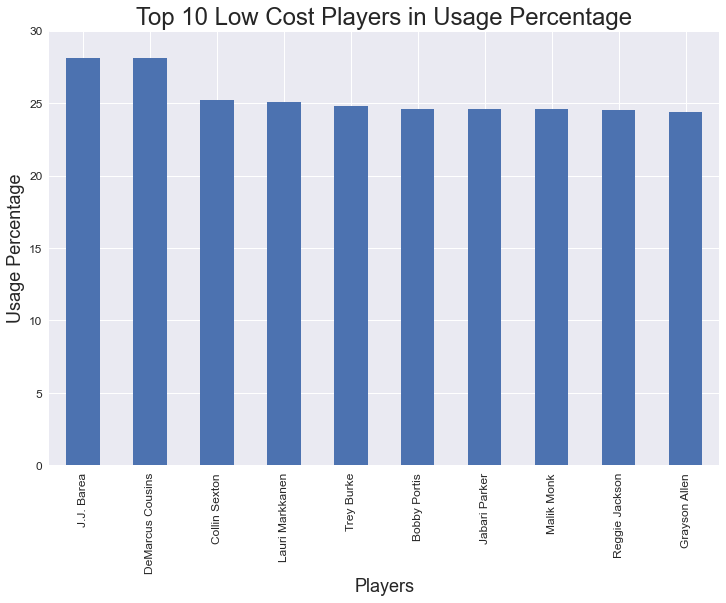

In [30]:
fig,ax = plt.subplots()
Top10LowSALHiUSG.plot.bar(x='Player',y='USG',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,30)
ax.set_title('Top 10 Low Cost Players in Usage Percentage',size=24)
ax.set_ylabel('Usage Percentage',size = 18)
ax.set_xlabel('Players',size = 18)
ax.tick_params(axis='both', which='major', labelsize=12)

### PER

#### Low Minutes, High PER

In [31]:
# Filter for players below median minutes played
# Adjust for players who barely played and saw high PER as a result
LowMinHiPER = (nbaStats19.loc[nbaStats19['MP'] < nbaStats19['MP'].median()][nbaStats19['MP'] > 164]
               [nbaStats19['PER'] > nbaStats19['PER'].median()][['Player','Pos','Age','Tm','PER','MP','Salary/Year','Years Remaining']])
# Sort and display the dataframe
Top10LowMinHiPER = LowMinHiPER.sort_values('PER', ascending = False).reset_index(drop = True).head(10)
Top10LowMinHiPER

<ipython-input-31-db99c43ad968>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  LowMinHiPER = (nbaStats19.loc[nbaStats19['MP'] < nbaStats19['MP'].median()][nbaStats19['MP'] > 164]


,Player,Pos,Age,Tm,PER,MP,Salary/Year,Years Remaining
0,Jonas Valančiūnas,C,26.0,TOT,24.4,"1,091.0","14,500,000.0",2
1,Boban Marjanović,C,30.0,TOT,24.2,681.0,"3,500,000.0",1
2,Mitchell Robinson,C,20.0,NYK,22.0,"1,360.0","1,732,959.0",2
3,Christian Wood,PF,23.0,TOT,21.9,251.0,"13,666,667.0",3
4,DeMarcus Cousins,C,28.0,GSW,21.4,771.0,"2,331,593.0",1
5,Thomas Bryant,C,21.0,WAS,21.0,"1,496.0","8,531,746.0",2
6,Richaun Holmes,C,25.0,PHO,20.7,"1,184.0","5,005,350.0",1
7,Willy Hernangómez,C,24.0,CHO,20.4,812.0,"1,727,145.0",1
8,Kevin Love,PF,30.0,CLE,19.5,598.0,"30,500,000.0",3
9,Derrick Rose,PG,30.0,MIN,19.5,"1,392.0","7,682,927.0",1


**NOTES:** This chart shows players who played less than the median amount of minutes but provided a high PER during their time on the court. *Mitchell Robinson* and *Willy Hernangomez* seem to be excellent targets, as they are under 25 yers old, cost under $1.75 million, and have PER's over 20.

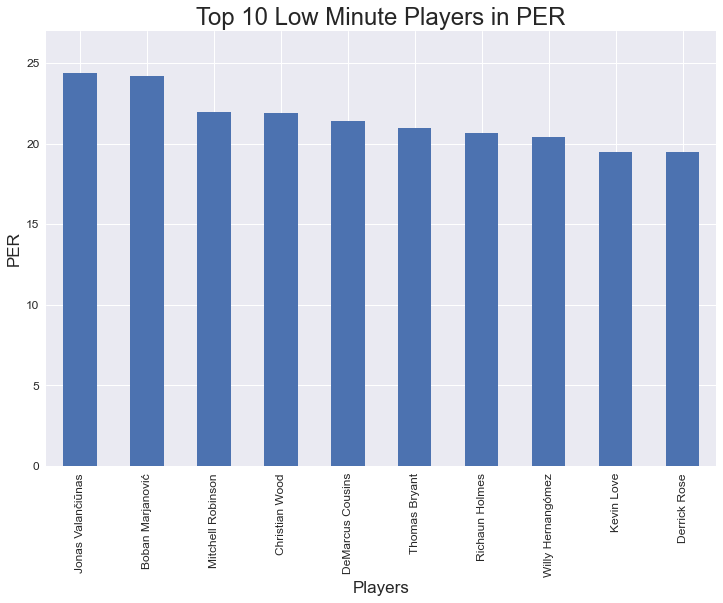

In [32]:
fig,ax = plt.subplots()
Top10LowMinHiPER.plot.bar(x='Player',y='PER',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,27)
ax.set_title('Top 10 Low Minute Players in PER',size=24)
ax.set_ylabel('PER',size = 17)
ax.set_xlabel('Players',size = 17)
ax.tick_params(axis='both', which='major', labelsize=12)

#### Low Salary, High PER

In [33]:
# Filter for players with salaries below the median
# Adjust for players who barely played and saw high PER as a result
LowSALHiPER = (nbaStats19.loc[nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()][nbaStats19['MP'] > 164]
               [nbaStats19['PER'] > nbaStats19['PER'].median()][['Player','Pos','Age','Tm','PER','MP','Salary/Year','Years Remaining']])
# Sort and display the dataframe
Top10LowSALHiPER = LowSALHiPER.sort_values('PER', ascending = False).reset_index(drop = True).head(10)
Top10LowSALHiPER

<ipython-input-33-bcb34cde15bb>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  LowSALHiPER = (nbaStats19.loc[nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()][nbaStats19['MP'] > 164]


,Player,Pos,Age,Tm,PER,MP,Salary/Year,Years Remaining
0,Boban Marjanović,C,30.0,TOT,24.2,681.0,"3,500,000.0",1
1,Hassan Whiteside,C,29.0,MIA,23.5,"1,674.0","2,320,044.0",1
2,Enes Kanter,C,26.0,TOT,22.3,"1,640.0","5,005,350.0",1
3,Mitchell Robinson,C,20.0,NYK,22.0,"1,360.0","1,732,959.0",2
4,JaVale McGee,C,31.0,LAL,21.8,"1,671.0","4,200,000.0",1
5,John Collins,PF,21.0,ATL,21.8,"1,829.0","4,137,302.0",1
6,DeMarcus Cousins,C,28.0,GSW,21.4,771.0,"2,331,593.0",1
7,Richaun Holmes,C,25.0,PHO,20.7,"1,184.0","5,005,350.0",1
8,Willy Hernangómez,C,24.0,CHO,20.4,812.0,"1,727,145.0",1
9,Nerlens Noel,C,24.0,OKC,19.3,"1,055.0","5,000,000.0",1


**NOTES:** This chart shows the players who are inexpensive, but offer a very high PER. All young players on this chart would be great targets, as they are inexpensive and provide excellent upside for the future. *Mitchell Robinson* is perhaps the most attractive target, as he is 20 years old and has a contract under $2 million for another 2 years.

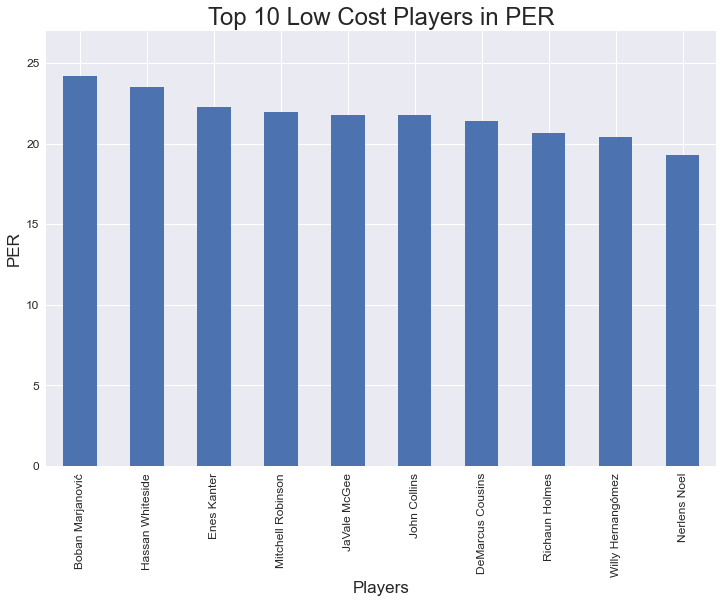

In [34]:
fig,ax = plt.subplots()
Top10LowSALHiPER.plot.bar(x='Player',y='PER',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,27)
ax.set_title('Top 10 Low Cost Players in PER',size=24)
ax.set_ylabel('PER',size = 17)
ax.set_xlabel('Players',size = 17)
ax.tick_params(axis='both', which='major', labelsize=12)

### BPM

#### Low Minutes, High BPM

In [35]:
# Filter for players with fewer minutes played than the median
# Adjust for players who barely played and saw high BPM as a result of lack of minutes
LowMinHiBPM = (nbaStats19.loc[nbaStats19['MP'] < nbaStats19['MP'].median()][nbaStats19['MP'] > 164]
               [nbaStats19['BPM'] > nbaStats19['BPM'].median()][['Player','Pos','Age','Tm','BPM','MP','Salary/Year','Years Remaining']])
# Sort and display the dataframe
Top10LowMinHiBPM = LowMinHiBPM.sort_values('BPM', ascending = False).reset_index(drop = True).head(10)
Top10LowMinHiBPM

<ipython-input-35-8e67c60eb5be>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  LowMinHiBPM = (nbaStats19.loc[nbaStats19['MP'] < nbaStats19['MP'].median()][nbaStats19['MP'] > 164]


,Player,Pos,Age,Tm,BPM,MP,Salary/Year,Years Remaining
0,Mitchell Robinson,C,20.0,NYK,5.7,"1,360.0","1,732,959.0",2
1,Robert Williams,C,21.0,BOS,4.4,283.0,"2,845,948.0",2
2,Nerlens Noel,C,24.0,OKC,3.9,"1,055.0","5,000,000.0",1
3,Kevon Looney,C,22.0,GSW,3.7,"1,481.0","5,000,000.0",2
4,DeMarcus Cousins,C,28.0,GSW,3.6,771.0,"2,331,593.0",1
5,Damian Jones,C,23.0,GSW,3.0,410.0,"1,857,078.0",2
6,Robert Covington,SF,28.0,TOT,2.4,"1,203.0","12,556,908.0",2
7,Khem Birch,C,26.0,ORL,2.4,643.0,"3,000,000.0",1
8,Daniel Theis,C,26.0,BOS,2.3,908.0,"5,000,000.0",1
9,Victor Oladipo,SG,26.0,IND,2.3,"1,147.0","21,000,000.0",1


**NOTES:** *Mitchell Robinson, Nerlens Noel,* and *Kevon Looney* are all excellent targets as they cost $5 million or less, are under 25 years old, and held a high BPM. Additionally, *Mitchell Robinson* and *Kevon Looney* still have 2 years remaining on their contract, providing low risk for an increase in cost in the near future.

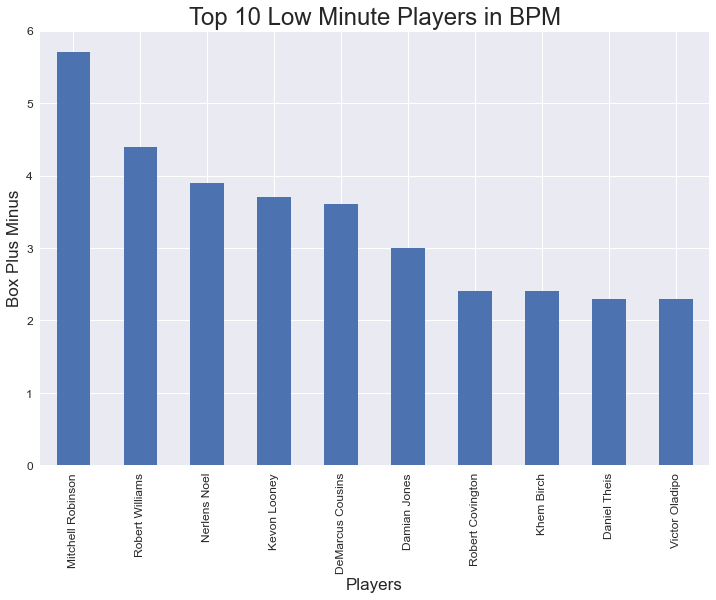

In [36]:
fig,ax = plt.subplots()
Top10LowMinHiBPM.plot.bar(x='Player',y='BPM',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,6)
ax.set_title('Top 10 Low Minute Players in BPM',size=24)
ax.set_ylabel('Box Plus Minus',size = 17)
ax.set_xlabel('Players',size = 17)
ax.tick_params(axis='both', which='major', labelsize=12)

#### Low Salary, High BPM

In [37]:
# Filter data for players with salaries below the median
# Adjust for players who barely played and saw high BPM as a result of lack of minutes
LowSALHiBPM = (nbaStats19.loc[nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()][nbaStats19['MP'] > 164]
               [nbaStats19['BPM'] > nbaStats19['BPM'].median()][['Player','Pos','Age','Tm','BPM','MP','Salary/Year','Years Remaining']])
# Sort and display the dataframe
Top10LowSALHiBPM = LowSALHiBPM.sort_values('BPM', ascending = False).reset_index(drop = True).head(10)
Top10LowSALHiBPM

<ipython-input-37-c37184353a81>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  LowSALHiBPM = (nbaStats19.loc[nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()][nbaStats19['MP'] > 164]


,Player,Pos,Age,Tm,BPM,MP,Salary/Year,Years Remaining
0,Mitchell Robinson,C,20.0,NYK,5.7,"1,360.0","1,732,959.0",2
1,Robert Williams,C,21.0,BOS,4.4,283.0,"2,845,948.0",2
2,Nerlens Noel,C,24.0,OKC,3.9,"1,055.0","5,000,000.0",1
3,Kevon Looney,C,22.0,GSW,3.7,"1,481.0","5,000,000.0",2
4,DeMarcus Cousins,C,28.0,GSW,3.6,771.0,"2,331,593.0",1
5,Damian Jones,C,23.0,GSW,3.0,410.0,"1,857,078.0",2
6,Marc Gasol,C,34.0,TOT,2.8,"2,436.0","2,628,872.0",2
7,Jarrett Allen,C,20.0,BRK,2.5,"2,096.0","3,909,902.0",1
8,Khem Birch,C,26.0,ORL,2.4,643.0,"3,000,000.0",1
9,Daniel Theis,C,26.0,BOS,2.3,908.0,"5,000,000.0",1


**NOTES:** This chart shows low cost players with the highest BPMs. Again, *Mitchell Robinson, Nerlens Noel,* and *Kevon Looney* look to be excellent targets due to their high BPM, low salaries, and young ages.

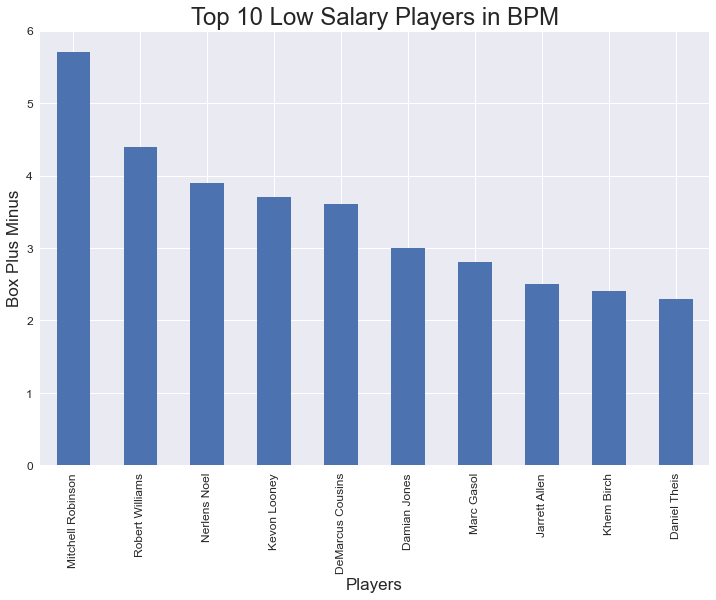

In [38]:
fig,ax = plt.subplots()
Top10LowSALHiBPM.plot.bar(x='Player',y='BPM',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,6)
ax.set_title('Top 10 Low Salary Players in BPM',size=24)
ax.set_ylabel('Box Plus Minus',size = 17)
ax.set_xlabel('Players',size = 17)
ax.tick_params(axis='both', which='major', labelsize=12)

## Relationships Between Key Statistics
    In this section, I run regressions to determine how key statistics correlate with a player's win share. I will 
    look at BPM to Win Share, PER to Win Share, Assists to Win Share, Points to Win Share, Rebound to Win Share, 
    Steals to Win Share, and Blocks to Win Share, comparing the 10 year correlations I find to determine which 
    statistics make the largest positive impact on a player's team wins. I will later use the correllation 
    coefficients to determine a player's value (relating value to team wins for which the player is responsible).

### BPM to Win Share

In [39]:
BPMvWS = nbaStats10yr.loc[nbaStats10yr['MP'] > 164][['Player','BPM','WS']]
BPM_to_WS = smf.ols('WS ~ BPM',data=BPMvWS).fit()

In [40]:
BPM_to_WS.rsquared

0.6738143926161737

In [41]:
print(BPM_to_WS.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     8581.
Date:                Fri, 01 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:08:12   Log-Likelihood:                -7955.1
No. Observations:                4156   AIC:                         1.591e+04
Df Residuals:                    4154   BIC:                         1.593e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7206      0.027    139.128      0.0

In [42]:
BPMvWS['yhat'] = BPM_to_WS.predict()

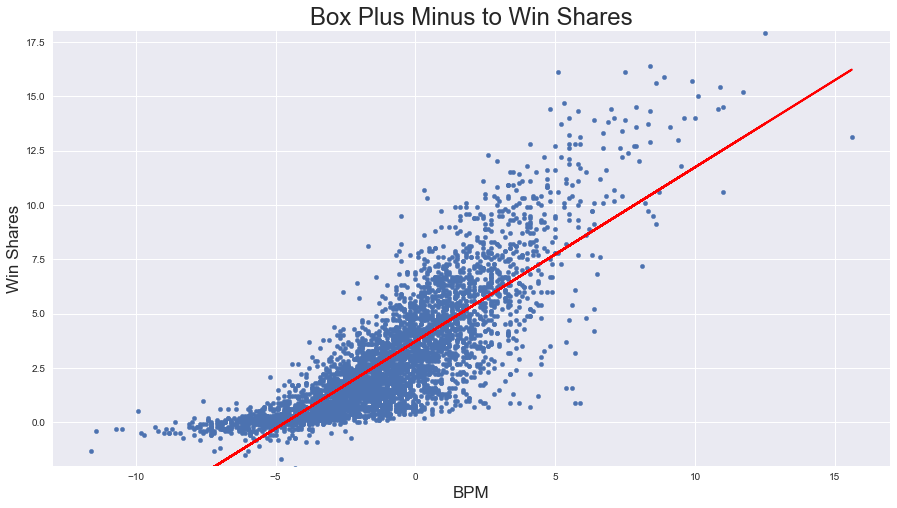

In [43]:
fig,ax = plt.subplots()
BPMvWS.plot.scatter(y='WS',x='BPM',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-2,18)
ax.set_title('Box Plus Minus to Win Shares',size=24)
ax.set_ylabel('Win Shares',size = 17)
ax.set_xlabel('Box Plus Minus',size = 17)
BPMvWS.set_index('BPM')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** There is a very strong correlation between Bow Plus Minus and Win Shares. This shows that the more positive the point differential while a player is on the court, the more wins he will add for his team. This further shows the importance of the statistic BPM, as it has a high correlation with wins.

### PER to Win Share

In [44]:
PERvWS = nbaStats10yr.loc[nbaStats10yr['MP'] > 164][['Player','PER','WS']]
PER_to_WS = smf.ols('WS ~ PER',data=PERvWS).fit()

In [45]:
PER_to_WS.rsquared

0.6013549784390977

In [46]:
print(PER_to_WS.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     6266.
Date:                Fri, 01 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:08:15   Log-Likelihood:                -8371.9
No. Observations:                4156   AIC:                         1.675e+04
Df Residuals:                    4154   BIC:                         1.676e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.8088      0.090    -42.298      0.0

In [47]:
PERvWS['yhat'] = PER_to_WS.predict()

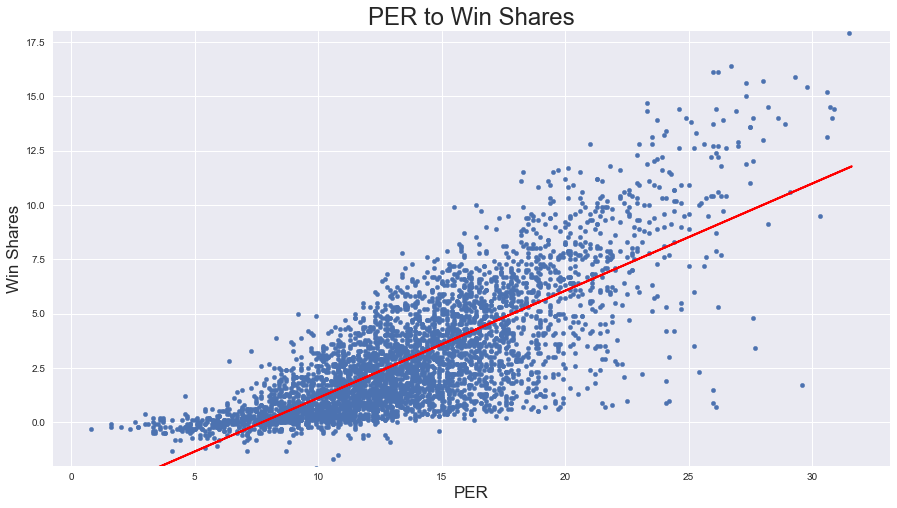

In [48]:
fig,ax = plt.subplots()
PERvWS.plot.scatter(y='WS',x='PER',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-2,18)
ax.set_title('PER to Win Shares',size=24)
ax.set_ylabel('Win Shares',size = 17)
ax.set_xlabel('Player Efficiency Rating',size = 17)
PERvWS.set_index('PER')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** There is a high correlation between PER and win shares, showing PER to be an extremely important statistic in determining a player's value. However, this correlation is lower than the correlation between BPM and Win shares, showing BPM to be a more valuable statistic in determining value.

### USG to Win Shares

In [49]:
USGvWS = nbaStats10yr.loc[nbaStats10yr['MP'] > 164][['Player','USG','WS']].dropna()
USG_to_WS = smf.ols('WS ~ USG',data=USGvWS).fit()

In [50]:
USG_to_WS.rsquared

0.15556328166862865

In [51]:
print(USG_to_WS.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     684.9
Date:                Fri, 01 Jan 2021   Prob (F-statistic):          1.02e-138
Time:                        23:08:17   Log-Likelihood:                -8904.2
No. Observations:                3720   AIC:                         1.781e+04
Df Residuals:                    3718   BIC:                         1.782e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3231      0.170     -7.788      0.0

In [52]:
USGvWS['yhat'] = USG_to_WS.predict()

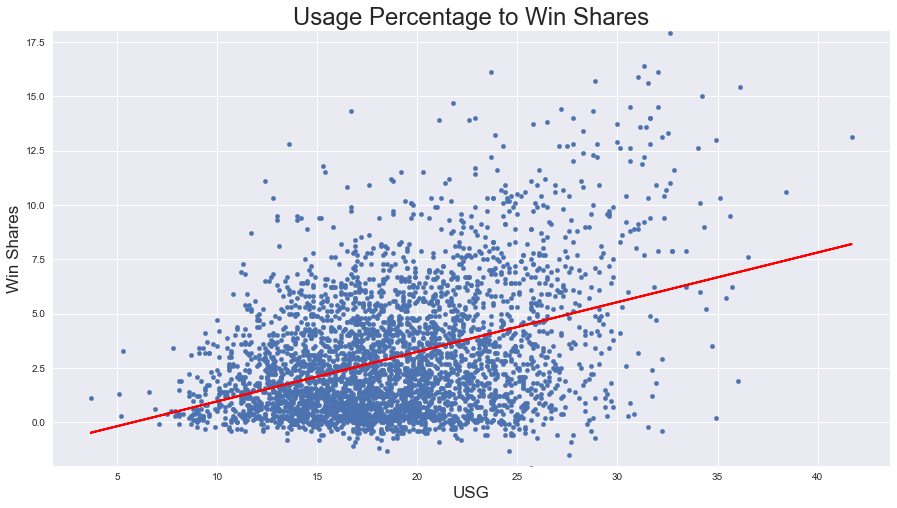

In [53]:
fig,ax = plt.subplots()
USGvWS.plot.scatter(y='WS',x='USG',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-2,18)
ax.set_title('Usage Percentage to Win Shares',size=24)
ax.set_ylabel('Win Shares',size = 17)
ax.set_xlabel('Usage Percentage',size = 17)
USGvWS.set_index('USG')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** I found there was a positive correlation between Usage and Win Shares in 2017. However, its correlation was lower than both that of BPM and PER, showing it to be an inferior statistic in determining a player's value. Nevertheless, a player with a high usage rate does carry a higher value than a player with a low usage rate due to the positive correlation.

### Assists to Win Share

In [54]:
ASTvWS = nbaStats10yr.loc[nbaStats10yr['MP'] > 164][['Player','AST','WS']]
AST_to_WS = smf.ols('WS ~ AST',data=ASTvWS).fit()

In [55]:
AST_to_WS.rsquared

0.3383056529820492

In [56]:
print(AST_to_WS.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     2124.
Date:                Fri, 01 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:08:20   Log-Likelihood:                -9424.9
No. Observations:                4156   AIC:                         1.885e+04
Df Residuals:                    4154   BIC:                         1.887e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3305      0.051     26.255      0.0

In [57]:
ASTvWS['yhat'] = AST_to_WS.predict()

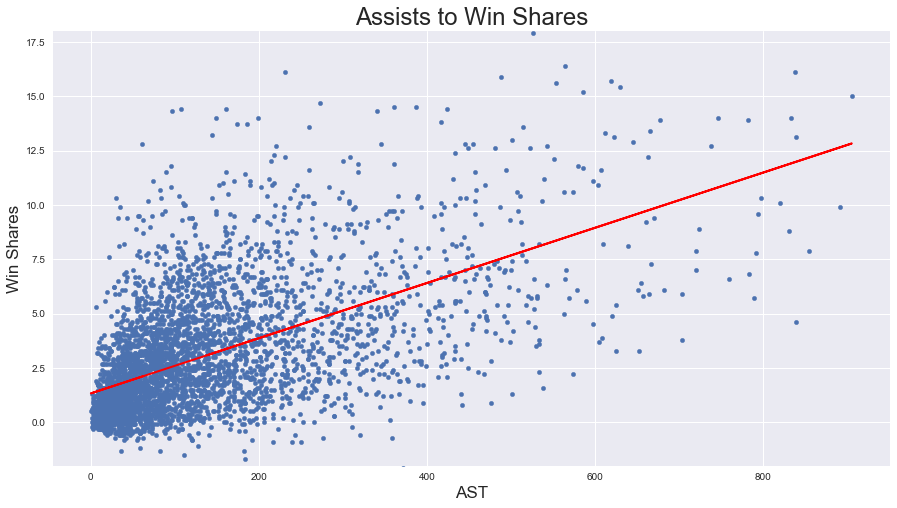

In [58]:
fig,ax = plt.subplots()
ASTvWS.plot.scatter(y='WS',x='AST',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-2,18)
ax.set_title('Assists to Win Shares',size=24)
ax.set_ylabel('Win Shares',size = 17)
ax.set_xlabel('Assists',size = 17)
ASTvWS.set_index('AST')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** Out of rebounds, points, and assists, assists had the lowest correlation to win shares, showing it to be the least valuable of the 3 statistics. Nevertheless, its positive correlation does show that it carries some value in a player's contribution, but not as high a value as rebounds and points.

### Points to Win Share

In [59]:
PTSvWS = nbaStats10yr.loc[nbaStats10yr['MP'] > 164][['Player','PTS','WS']]
PTS_to_WS = smf.ols('WS ~ PTS',data=PTSvWS).fit()

In [60]:
PTS_to_WS.rsquared

0.6839718477023737

In [61]:
print(PTS_to_WS.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     8990.
Date:                Fri, 01 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:08:24   Log-Likelihood:                -7889.3
No. Observations:                4156   AIC:                         1.578e+04
Df Residuals:                    4154   BIC:                         1.580e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1813      0.042     -4.363      0.0

In [62]:
PTSvWS['yhat'] = PTS_to_WS.predict()

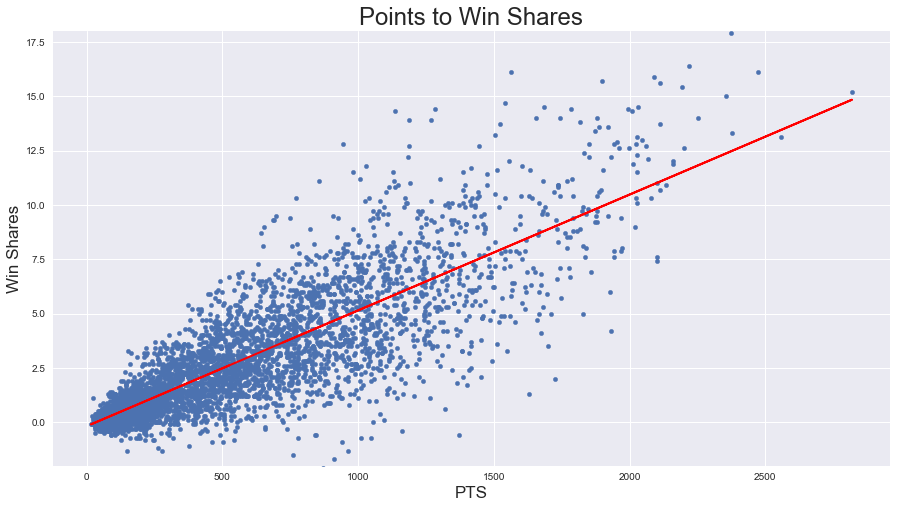

In [63]:
fig,ax = plt.subplots()
PTSvWS.plot.scatter(y='WS',x='PTS',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-2,18)
ax.set_title('Points to Win Shares',size=24)
ax.set_ylabel('Win Shares',size = 17)
ax.set_xlabel('Points',size = 17)
PTSvWS.set_index('PTS')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** Points had the highest correlation out of assists, rebounds, and points, showing that players with high point totals carry a higher value than players with high assist and rebound values. This is to be expected, as wins are determined by the team with more points, not necessarily more assists or rebounds.

### Rebounds to Win Share

In [64]:
TRBvWS = nbaStats10yr.loc[nbaStats10yr['MP'] > 164][['Player','TRB','WS']]
TRB_to_WS = smf.ols('WS ~ TRB',data=TRBvWS).fit()

In [65]:
TRB_to_WS.rsquared

0.5496005790709452

In [66]:
print(TRB_to_WS.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     5069.
Date:                Fri, 01 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:08:27   Log-Likelihood:                -8625.6
No. Observations:                4156   AIC:                         1.726e+04
Df Residuals:                    4154   BIC:                         1.727e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1920      0.049      3.912      0.0

In [67]:
TRBvWS['yhat'] = TRB_to_WS.predict()

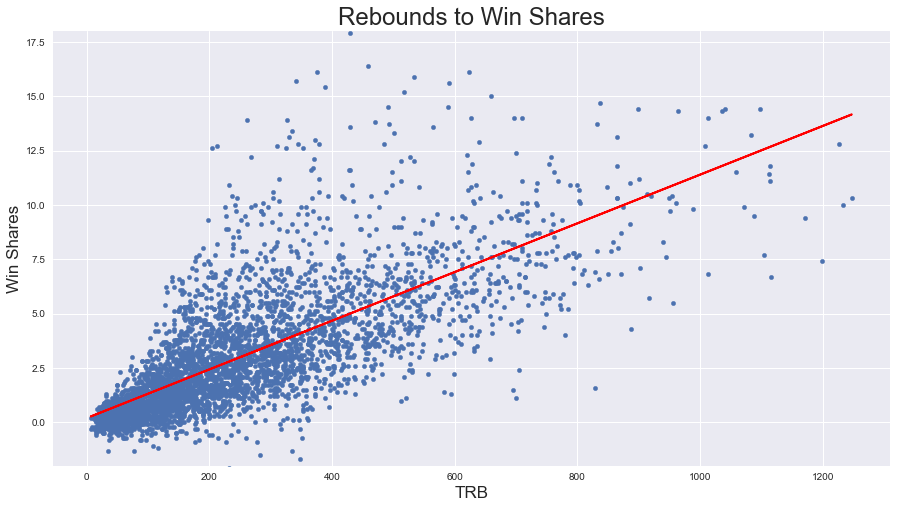

In [68]:
fig,ax = plt.subplots()
TRBvWS.plot.scatter(y='WS',x='TRB',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-2,18)
ax.set_title('Rebounds to Win Shares',size=24)
ax.set_ylabel('Win Shares',size = 17)
ax.set_xlabel('Rebounds',size = 17)
TRBvWS.set_index('TRB')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** I found that Rebounds had a stronger correlation to Win Shares than Assists, supporting an argument that it is a more important statistic than Assists. Therefore, one can conclude that rebounds should carry over more value than assists, and players who have a higher number of rebounds should be valued higher than players who have the same relative number of assists.

### Steals to Win Share

In [69]:
STLvWS = nbaStats10yr.loc[nbaStats10yr['MP'] > 164][['Player','STL','WS']]
STL_to_WS = smf.ols('WS ~ STL',data=STLvWS).fit()

In [70]:
STL_to_WS.rsquared

0.44928266757701607

In [71]:
print(STL_to_WS.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     3389.
Date:                Fri, 01 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:08:30   Log-Likelihood:                -9043.4
No. Observations:                4156   AIC:                         1.809e+04
Df Residuals:                    4154   BIC:                         1.810e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3302      0.056      5.894      0.0

In [72]:
STLvWS['yhat'] = STL_to_WS.predict()

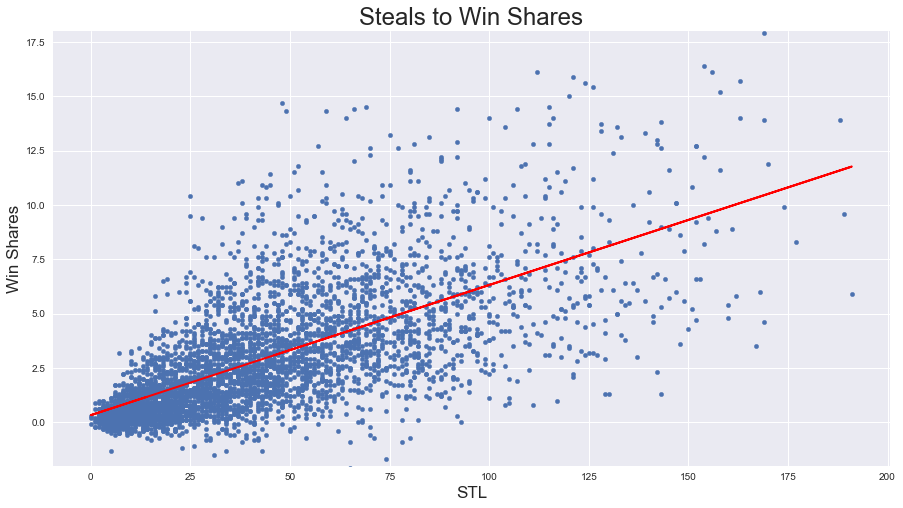

In [73]:
fig,ax = plt.subplots()
STLvWS.plot.scatter(y='WS',x='STL',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-2,18)
ax.set_title('Steals to Win Shares',size=24)
ax.set_ylabel('Win Shares',size = 17)
ax.set_xlabel('Steals',size = 17)
STLvWS.set_index('STL')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** Out of the defensive statistics, I found that Steals had a stronger correlation to Win Shares than blocks. This makes sense because a steal translates to possession and a scoring opportunity for the team causing the steal, while blocks often do not change possession. (see next graph)

### Blocks to Win Share

In [74]:
BLKvWS = nbaStats10yr.loc[nbaStats10yr['MP'] > 164][['Player','BLK','WS']]
BLK_to_WS = smf.ols('WS ~ BLK',data=BLKvWS).fit()

In [75]:
BLK_to_WS.rsquared

0.2844218367667327

In [76]:
print(BLK_to_WS.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     1651.
Date:                Fri, 01 Jan 2021   Prob (F-statistic):          3.08e-304
Time:                        23:08:33   Log-Likelihood:                -9587.6
No. Observations:                4156   AIC:                         1.918e+04
Df Residuals:                    4154   BIC:                         1.919e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5986      0.050     31.671      0.0

In [77]:
BLKvWS['yhat'] = BLK_to_WS.predict()

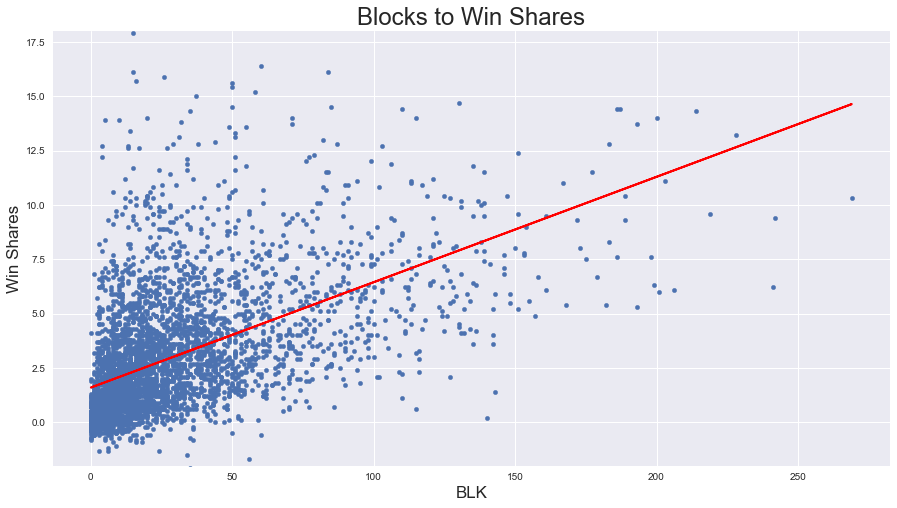

In [78]:
fig,ax = plt.subplots()
BLKvWS.plot.scatter(y='WS',x='BLK',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-2,18)
ax.set_title('Blocks to Win Shares',size=24)
ax.set_ylabel('Win Shares',size = 17)
ax.set_xlabel('Blocks',size = 17)
BLKvWS.set_index('BLK')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** There is a low, positive correllation between a player's blocks total and win share.

## Model for Valuation of Players
    In order to determine a player's value, I multiplied their different statistics to their given correlation 
    coefficient to win shares to determine the predicted win share for each stat. I then took added the products 
    together and divided by the number of statistics used to find the average win share predicted for each player. 
    By using the correllation coefficients from the 10 year dataframe, I am eliminating a large portion of the 
    penalty players' win share receives from the strength of their teammates by using a larger data pool. 
    Therefore, I am generating a more accurate estimation of the players' value.
    
    Additionally, I look into the top valued players at each position and look into top valued players below the 
    median salary and below 26 years old. This allows someone to more easily identify potential targets. I 
    elaborate on the salaries of the different players and use rhetoric to discuss players who look to be of high 
    value due to their age or salary.
    
    Finally compared the model to the all star teams in 5 previous years to assess its accuracy, and further 
    compared player values given salaries and positions. I found it to have 74% accuracy in predicting all star 
    teams. I believe some of the discrepencies come from strengths of teammates, an issue I attempted to diminish. 
    For example, Klay Thompson was an All Star in many of the seasons, but since Steph Curry and Kevin Durant were 
    his teammates, his win share was pushed lower, dropping him out of the top players. However, despite this 
    issue, I believe that my results are largely accurate and are useful in identifying valuable players, as well 
    as undervalued or underpaid players.

In [79]:
nbaStats19['Value'] = ((nbaStats19['BPM']*.8013 + nbaStats19['PER']*.4930 + nbaStats19['USG']*.2283
                          + nbaStats19['PTS']*.0053 + nbaStats19['AST']*.0127 + nbaStats19['BLK']*.0485
                          + nbaStats19['TRB']*.0112 + nbaStats19['STL']*.0599)/8)
nbaStats19['Value'] = nbaStats19['Value'].round(decimals=2)

nbaStats19['Value/$1M'] = (nbaStats19['Value']/nbaStats19['Salary/Year']) * 1000000
nbaStats19['Value/$1M'] = nbaStats19['Value/$1M'].round(decimals=2)

## Top 26 Players 2019

In [80]:
nbaValuation19 = nbaStats19.loc[nbaStats19['MP'] > 164].sort_values('Value', ascending = False).reset_index(drop = True)
nbaValuation19[['Player','Pos','Age','MP','Value']].head(26)

,Player,Pos,Age,MP,Value
0,James Harden,PG,29.0,"2,867.0",9.27
1,Giannis Antetokounmpo,PF,24.0,"2,358.0",8.51
2,Nikola Jokić,C,23.0,"2,504.0",7.69
3,Russell Westbrook,PG,30.0,"2,630.0",7.58
4,Karl-Anthony Towns,C,23.0,"2,545.0",7.38
5,Anthony Davis,C,25.0,"1,850.0",7.29
6,Paul George,SF,28.0,"2,841.0",7.12
7,Nikola Vučević,C,28.0,"2,510.0",7.09
8,Andre Drummond,C,25.0,"2,647.0",7.05
9,Rudy Gobert,C,26.0,"2,577.0",6.92


## Top Value Under Median Salary

In [81]:
nbaValuationLoSal = nbaStats19.loc[nbaStats19['Year'] == 2019][nbaStats19['MP'] > 164][nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()].sort_values('Value', ascending = False).reset_index(drop = True)
nbaValuationLoSal[['Player','Pos','Age','MP','Value','Salary/Year','Years Remaining']].head(26)

<ipython-input-81-d684562d8091>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nbaValuationLoSal = nbaStats19.loc[nbaStats19['Year'] == 2019][nbaStats19['MP'] > 164][nbaStats19['Salary/Year'] < nbaStats19['Salary/Year'].median()].sort_values('Value', ascending = False).reset_index(drop = True)


,Player,Pos,Age,MP,Value,Salary/Year,Years Remaining
0,Marc Gasol,C,34.0,"2,436.0",5.19,"2,628,872.0",2
1,Hassan Whiteside,C,29.0,"1,674.0",5.16,"2,320,044.0",1
2,JaVale McGee,C,31.0,"1,671.0",4.83,"4,200,000.0",1
3,Willie Cauley-Stein,C,25.0,"2,213.0",4.73,"4,100,000.0",2
4,Mitchell Robinson,C,20.0,"1,360.0",4.61,"1,732,959.0",2
5,Jarrett Allen,C,20.0,"2,096.0",4.59,"3,909,902.0",1
6,John Collins,PF,21.0,"1,829.0",4.37,"4,137,302.0",1
7,Enes Kanter,C,26.0,"1,640.0",4.27,"5,005,350.0",1
8,DeMarcus Cousins,C,28.0,771.0,3.89,"2,331,593.0",1
9,Nerlens Noel,C,24.0,"1,055.0",3.83,"5,000,000.0",1


## Top Value per Dollar for Players in Top 50%

In [82]:
nbaValuationPdollar = nbaValuation19.loc[nbaValuation19['Value'] > nbaValuation19['Value'].median()]
nbaValuationPdollar[['Player','Pos','Age','MP','Value','Value/$1M','Salary/Year','Years Remaining']].sort_values('Value/$1M', ascending = False).reset_index(drop = True).head(26)

,Player,Pos,Age,MP,Value,Value/$1M,Salary/Year,Years Remaining
0,Mitchell Robinson,C,20.0,"1,360.0",4.61,2.66,"1,732,959.0",2
1,Hassan Whiteside,C,29.0,"1,674.0",5.16,2.22,"2,320,044.0",1
2,Marc Gasol,C,34.0,"2,436.0",5.19,1.97,"2,628,872.0",2
3,DeAndre' Bembry,SG,24.0,"1,931.0",3.25,1.75,"1,857,078.0",2
4,DeMarcus Cousins,C,28.0,771.0,3.89,1.67,"2,331,593.0",1
5,Reggie Jackson,PG,28.0,"2,289.0",3.76,1.61,"2,331,593.0",1
6,Alex Len,C,25.0,"1,544.0",3.52,1.52,"2,320,000.0",1
7,Kent Bazemore,SG,29.0,"1,643.0",3.18,1.37,"2,320,044.0",1
8,Dewayne Dedmon,C,29.0,"1,609.0",3.81,1.33,"2,866,667.0",5
9,Jeff Green,PF,32.0,"2,097.0",3.06,1.19,"2,564,753.0",1


## Top Value per Dollar Under Median Age, Top 50% Value

In [83]:
nbaValuationPdollarYoung = nbaValuation19.loc[nbaValuation19['Value'] > nbaValuation19['Value'].median()][nbaValuation19['Age'] < nbaValuation19['Age'].median()]
nbaValuationPdollarYoung[['Player','Pos','Age','MP','Value','Value/$1M','Salary/Year','Years Remaining']].sort_values('Value/$1M', ascending = False).reset_index(drop = True).head(26)

<ipython-input-83-b13aede58124>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nbaValuationPdollarYoung = nbaValuation19.loc[nbaValuation19['Value'] > nbaValuation19['Value'].median()][nbaValuation19['Age'] < nbaValuation19['Age'].median()]


,Player,Pos,Age,MP,Value,Value/$1M,Salary/Year,Years Remaining
0,Mitchell Robinson,C,20.0,"1,360.0",4.61,2.66,"1,732,959.0",2
1,DeAndre' Bembry,SG,24.0,"1,931.0",3.25,1.75,"1,857,078.0",2
2,Alex Len,C,25.0,"1,544.0",3.52,1.52,"2,320,000.0",1
3,Jarrett Allen,C,20.0,"2,096.0",4.59,1.17,"3,909,902.0",1
4,Willie Cauley-Stein,C,25.0,"2,213.0",4.73,1.15,"4,100,000.0",2
5,John Collins,PF,21.0,"1,829.0",4.37,1.06,"4,137,302.0",1
6,Maurice Harkless,SF,25.0,"1,415.0",3.05,0.84,"3,623,000.0",1
7,Nerlens Noel,C,24.0,"1,055.0",3.83,0.77,"5,000,000.0",1
8,Shai Gilgeous-Alexander,PG,20.0,"2,174.0",3.65,0.76,"4,818,426.0",2
9,Richaun Holmes,C,25.0,"1,184.0",3.66,0.73,"5,005,350.0",1


## Top Players By Position: 
    This section is designed for an easy view of top players by position for GMs to review and use in making
    transactional decisions. It also looks into low cost players and young players with high value at each 
    position.

### Point Guard

#### Top 10 PG

In [84]:
nbaValuation19.loc[nbaValuation19['Pos'] == 'PG'][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].reset_index(drop = True).head(10)

,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,James Harden,PG,29.0,9.27,0.21,"43,848,000.0",3
1,Russell Westbrook,PG,30.0,7.58,0.17,"44,211,146.0",3
2,Damian Lillard,PG,28.0,6.48,0.14,"45,525,391.0",5
3,Ben Simmons,PG,22.0,6.31,0.19,"33,930,000.0",5
4,Kyrie Irving,PG,26.0,6.22,0.18,"34,916,200.0",3
5,Kemba Walker,PG,28.0,6.2,0.17,"36,016,200.0",3
6,Stephen Curry,PG,30.0,6.18,0.14,"44,393,664.0",2
7,D'Angelo Russell,PG,22.0,5.79,0.19,"30,013,500.0",3
8,De'Aaron Fox,PG,21.0,5.48,0.19,"28,516,703.0",6
9,Mike Conley,PG,31.0,5.3,0.15,"34,504,132.0",1


**NOTES:** This chart shows the top 10 valued Point Guards, led heavily by *James Harden*. As the only player under $30 million with a contract lasting 6 years at age 21, *De'Aaron Fox* is an excellent target for a GM focused on the future and looking for a star at PG.

#### Top 10 PG in Value Per $1M in Salary

In [85]:
nbaValuation19.loc[nbaValuation19['Pos'] == 'PG'][nbaValuation19['Value'] > 2][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].sort_values('Value/$1M', ascending = False).reset_index(drop = True).head(10)

<ipython-input-85-dabde52c3d9d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nbaValuation19.loc[nbaValuation19['Pos'] == 'PG'][nbaValuation19['Value'] > 2][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].sort_values('Value/$1M', ascending = False).reset_index(drop = True).head(10)


,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,Shaquille Harrison,PG,25.0,2.8,1.67,"1,678,854.0",1
1,Reggie Jackson,PG,28.0,3.76,1.61,"2,331,593.0",1
2,Jalen Brunson,PG,22.0,2.44,1.41,"1,732,959.0",2
3,Tyler Johnson,PG,26.0,2.68,1.32,"2,028,594.0",1
4,Jeff Teague,PG,30.0,2.72,1.06,"2,564,753.0",1
5,J.J. Barea,PG,34.0,2.61,1.02,"2,564,753.0",1
6,Ryan Arcidiacono,PG,24.0,2.55,0.85,"3,000,000.0",2
7,T.J. McConnell,PG,26.0,2.76,0.79,"3,500,000.0",1
8,Trey Burke,PG,26.0,2.57,0.77,"3,333,333.0",3
9,Shai Gilgeous-Alexander,PG,20.0,3.65,0.76,"4,818,426.0",2


**NOTES:** *Shaquille Harrison* leads PGs in value per $1M of salary and is of high value. *Jalen Brunson* is another player who shows to be an excellent target, as he is ranked third and has 2 years remaining on his inexpensive contract.

#### Top 10 Low Cost PG

In [86]:
(nbaValuation19.loc[nbaValuation19['Pos'] == 'PG'][nbaValuation19['Salary/Year'] < nbaValuation19['Salary/Year'].median()]
 [nbaValuation19['MP'] > 164][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].reset_index(drop = True).head(10))

<ipython-input-86-10c0af044b47>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (nbaValuation19.loc[nbaValuation19['Pos'] == 'PG'][nbaValuation19['Salary/Year'] < nbaValuation19['Salary/Year'].median()]


,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,Reggie Jackson,PG,28.0,3.76,1.61,"2,331,593.0",1
1,Shai Gilgeous-Alexander,PG,20.0,3.65,0.76,"4,818,426.0",2
2,D.J. Augustin,PG,31.0,3.43,0.49,"7,000,000.0",3
3,Monte Morris,PG,23.0,3.38,0.47,"7,165,965.0",4
4,Collin Sexton,PG,20.0,2.93,0.52,"5,670,776.0",2
5,Kris Dunn,PG,24.0,2.84,0.58,"4,886,175.0",2
6,Elfrid Payton,PG,24.0,2.84,0.49,"5,760,000.0",1
7,Shaquille Harrison,PG,25.0,2.8,1.67,"1,678,854.0",1
8,T.J. McConnell,PG,26.0,2.76,0.79,"3,500,000.0",1
9,Jeff Teague,PG,30.0,2.72,1.06,"2,564,753.0",1


**NOTES:** This chart shows the top Point Guards priced below the median salary. *Shai Gilgeous-Alexander, Monte Morris, Colin Sexton*, and *Kris Dunn* are excellent options for a GM, as they are all under 25 and cost under $7.2 million for at least 2 more years.

#### Top 10 PG Under 26

In [87]:
(nbaValuation19.loc[nbaValuation19['Pos'] == 'PG'][nbaValuation19['Age'] < nbaValuation19['Age'].median()]
 [nbaValuation19['MP'] > 164][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].reset_index(drop = True).head(10))

<ipython-input-87-8c1d46a80e5d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (nbaValuation19.loc[nbaValuation19['Pos'] == 'PG'][nbaValuation19['Age'] < nbaValuation19['Age'].median()]


,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,Ben Simmons,PG,22.0,6.31,0.19,"33,930,000.0",5
1,D'Angelo Russell,PG,22.0,5.79,0.19,"30,013,500.0",3
2,De'Aaron Fox,PG,21.0,5.48,0.19,"28,516,703.0",6
3,Trae Young,PG,20.0,4.86,0.65,"7,449,136.0",2
4,Jamal Murray,PG,21.0,4.3,0.13,"33,930,000.0",5
5,Shai Gilgeous-Alexander,PG,20.0,3.65,0.76,"4,818,426.0",2
6,Spencer Dinwiddie,PG,25.0,3.58,0.3,"11,878,272.0",2
7,Derrick White,PG,24.0,3.5,0.24,"14,303,257.0",5
8,Dennis Schröder,PG,25.0,3.44,0.22,"15,500,000.0",1
9,Monte Morris,PG,23.0,3.38,0.47,"7,165,965.0",4


**NOTES:** *Ben Simmons* is the top ranked PG under 26 and is extremely valuable at age 22. However, perhaps the best budget option on the board is *Monte Morris*, who costs under $7.2 million for the next 4 years. Therefore, he would make a great target, along with *Trae Young* and *Shai Gildeous-Alexander*, who are also low cost for the next 2 years at age 20.

### Shooting Guard

#### Top 10 SG

In [88]:
nbaValuation19.loc[nbaValuation19['Pos'] == 'SG'][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].reset_index(drop = True).head(10)

,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,Bradley Beal,SG,25.0,6.31,0.19,"33,505,402.0",3
1,Luka Dončić,SG,19.0,5.7,0.63,"9,111,876.0",2
2,Jrue Holiday,SG,28.0,5.58,0.21,"26,575,556.0",2
3,DeMar DeRozan,SG,29.0,5.44,0.2,"27,739,975.0",1
4,Donovan Mitchell,SG,22.0,5.17,0.18,"28,032,682.0",6
5,Devin Booker,SG,22.0,4.95,0.15,"32,700,000.0",4
6,Lou Williams,SG,32.0,4.71,0.59,"8,000,000.0",1
7,Buddy Hield,SG,26.0,4.56,0.21,"21,500,000.0",4
8,Zach LaVine,SG,23.0,4.48,0.23,"19,500,000.0",2
9,Klay Thompson,SG,28.0,4.41,0.11,"39,290,400.0",4


**NOTES:** This chart rates the Shooting Guards around the league and provides a top 10. *Luca Doncic* ranks second at 19 years old, and this along with his low cost contract for the next 2 years makes him perhaps the top prospect on this board.

#### Top 10 SG in Value Per $1M in Salary

In [89]:
nbaValuation19.loc[nbaValuation19['Pos'] == 'SG'][nbaValuation19['Value'] > 2][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].sort_values('Value/$1M', ascending = False).reset_index(drop = True).head(10)

<ipython-input-89-11cb14a1eb0a>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nbaValuation19.loc[nbaValuation19['Pos'] == 'SG'][nbaValuation19['Value'] > 2][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].sort_values('Value/$1M', ascending = False).reset_index(drop = True).head(10)


,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,DeAndre' Bembry,SG,24.0,3.25,1.75,"1,857,078.0",2
1,Kent Bazemore,SG,29.0,3.18,1.37,"2,320,044.0",1
2,Damyean Dotson,SG,24.0,2.52,1.26,"2,000,000.0",2
3,Bryn Forbes,SG,25.0,2.78,1.16,"2,395,574.0",2
4,Langston Galloway,SG,27.0,2.13,1.05,"2,028,594.0",1
5,E'Twaun Moore,SG,29.0,2.09,0.9,"2,331,593.0",1
6,Wayne Ellington,SG,31.0,2.3,0.77,"3,005,225.0",1
7,Kevin Huerter,SG,20.0,2.68,0.76,"3,507,638.0",2
8,Landry Shamet,SG,21.0,2.2,0.75,"2,929,191.0",2
9,Josh Okogie,SG,20.0,2.53,0.75,"3,369,472.0",2


**NOTES:** *Deandre Bembry* is the clear most valuable target at the SG position, as he leads this group in both value and value per 1 million in salary, at age 24 and with 2 years remaining on his contract. He is also the cheapest player, with a salary under 2 million dollars.

#### Top 10 Low Cost SG

In [90]:
(nbaValuation19.loc[nbaValuation19['Pos'] == 'SG'][nbaValuation19['Salary/Year'] < nbaValuation19['Salary/Year'].median()]
 [nbaValuation19['MP'] > 164][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].reset_index(drop = True).head(10))

<ipython-input-90-eb7436ba30a7>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (nbaValuation19.loc[nbaValuation19['Pos'] == 'SG'][nbaValuation19['Salary/Year'] < nbaValuation19['Salary/Year'].median()]


,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,Justin Holiday,SG,29.0,3.36,0.56,"6,006,420.0",3
1,DeAndre' Bembry,SG,24.0,3.25,1.75,"1,857,078.0",2
2,Kent Bazemore,SG,29.0,3.18,1.37,"2,320,044.0",1
3,Josh Jackson,SG,21.0,3.13,0.64,"4,886,175.0",2
4,Bryn Forbes,SG,25.0,2.78,1.16,"2,395,574.0",2
5,Kevin Huerter,SG,20.0,2.68,0.76,"3,507,638.0",2
6,Pat Connaughton,SG,26.0,2.61,0.49,"5,333,333.0",3
7,Josh Okogie,SG,20.0,2.53,0.75,"3,369,472.0",2
8,Damyean Dotson,SG,24.0,2.52,1.26,"2,000,000.0",2
9,Josh Hart,SG,23.0,2.45,0.7,"3,491,159.0",1


**NOTES:** Each of these players is extremely valuable, as most are very young, and all are rated excellently. However, *Deandre Bembry* stands out among the group, with the highest Value/$1M at 1.75 and a salary of 1.86 million for the next 2 years at age 24. Therefore, he appears to be an outstanding target.

#### Top 10 SG Under 26

In [91]:
(nbaValuation19.loc[nbaValuation19['Pos'] == 'SG'][nbaValuation19['Age'] < nbaValuation19['Age'].median()]
 [nbaValuation19['MP'] > 164][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].reset_index(drop = True).head(10))

<ipython-input-91-d668be190ecb>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (nbaValuation19.loc[nbaValuation19['Pos'] == 'SG'][nbaValuation19['Age'] < nbaValuation19['Age'].median()]


,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,Bradley Beal,SG,25.0,6.31,0.19,"33,505,402.0",3
1,Luka Dončić,SG,19.0,5.7,0.63,"9,111,876.0",2
2,Donovan Mitchell,SG,22.0,5.17,0.18,"28,032,682.0",6
3,Devin Booker,SG,22.0,4.95,0.15,"32,700,000.0",4
4,Zach LaVine,SG,23.0,4.48,0.23,"19,500,000.0",2
5,Josh Richardson,SG,25.0,3.96,0.35,"11,200,000.0",2
6,Marcus Smart,SG,24.0,3.95,0.28,"13,892,856.0",2
7,DeAndre' Bembry,SG,24.0,3.25,1.75,"1,857,078.0",2
8,Jaylen Brown,SG,22.0,3.2,0.12,"25,750,000.0",4
9,Josh Jackson,SG,21.0,3.13,0.64,"4,886,175.0",2


**NOTES:** This chart shows the top SGs under 26 years old. *Luka Doncic* is an extremely valuable player who costs under 9.2 million with 2 years remaining on his contract at age 19. Therefore, he is an excellent option for any GM. Additionally, *DeAndre Bembry* is, again, an excellent option. He is 24 years old, high value, and costs under 1.9 million for the next 2 years. His Value/1M is 1.75, by far the highest of the group, combining with the other factors to make *DeAndre Bembry* an awesome target.

### Small Forward

#### Top 10 SF

In [92]:
nbaValuation19.loc[nbaValuation19['Pos'] == 'SF'][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].reset_index(drop = True).head(10)

,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,Paul George,SF,28.0,7.12,0.17,"42,343,176.0",5
1,Kevin Durant,SF,30.0,6.46,0.16,"40,918,900.0",3
2,LeBron James,SF,34.0,6.4,0.15,"41,625,032.0",3
3,Kawhi Leonard,SF,27.0,5.88,0.17,"35,197,650.0",2
4,Jimmy Butler,SF,29.0,5.06,0.14,"36,016,200.0",3
5,Khris Middleton,SF,27.0,4.56,0.12,"36,724,138.0",4
6,Danilo Gallinari,SF,30.0,4.53,0.22,"20,475,000.0",3
7,Jayson Tatum,SF,20.0,4.21,0.15,"28,816,285.0",6
8,Bojan Bogdanović,SF,29.0,3.84,0.21,"18,700,000.0",3
9,Andrew Wiggins,SF,23.0,3.65,0.12,"31,579,390.0",3


**NOTES:** This chart shows the top 10 valued SFs. Since all are either expensive or veterans, it is tough to find a player that truly sticks out from the pack. *Jayson Tatum* would have to be the noted player here, as he is under $30 million with 6 years remaining on his contract and the 8th best SF at age 20.

#### Top 10 SF in Value Per $1M in Salary

In [93]:
nbaValuation19.loc[nbaValuation19['Pos'] == 'SF'][nbaValuation19['Value'] > 2][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].sort_values('Value/$1M', ascending = False).reset_index(drop = True).head(10)

<ipython-input-93-c580fc5d2119>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nbaValuation19.loc[nbaValuation19['Pos'] == 'SF'][nbaValuation19['Value'] > 2][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].sort_values('Value/$1M', ascending = False).reset_index(drop = True).head(10)


,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,Torrey Craig,SF,28.0,2.31,1.38,"1,678,854.0",1
1,Rodions Kurucs,SF,20.0,2.2,1.21,"1,820,610.0",2
2,Bruno Caboclo,SF,23.0,2.03,0.94,"2,155,814.0",2
3,Maurice Harkless,SF,25.0,3.05,0.84,"3,623,000.0",1
4,Dorian Finney-Smith,SF,25.0,2.93,0.73,"4,000,000.0",2
5,Wesley Matthews,SF,32.0,2.55,0.7,"3,623,000.0",1
6,Mikal Bridges,SF,22.0,3.29,0.66,"4,958,362.0",2
7,Jake Layman,SF,24.0,2.42,0.63,"3,850,634.0",2
8,Miles Bridges,SF,20.0,2.89,0.62,"4,677,906.0",2
9,Stanley Johnson,SF,22.0,2.16,0.57,"3,801,000.0",1


**NOTES:** *Rodions Kurucs* seems to be a very good prospect, as he is 2nd in this category, is 20 years old, and has a salary under $2 million for the next 2 years. Therefore, it appears that he would make an excellent target for a GM.

#### Top 10 Low Cost SF

In [94]:
(nbaValuation19.loc[nbaValuation19['Pos'] == 'SF'][nbaValuation19['Salary/Year'] < nbaValuation19['Salary/Year'].median()]
 [nbaValuation19['MP'] > 164][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].reset_index(drop = True).head(10))

<ipython-input-94-1b54fc5fa7c8>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (nbaValuation19.loc[nbaValuation19['Pos'] == 'SF'][nbaValuation19['Salary/Year'] < nbaValuation19['Salary/Year'].median()]


,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,Mikal Bridges,SF,22.0,3.29,0.66,"4,958,362.0",2
1,Maurice Harkless,SF,25.0,3.05,0.84,"3,623,000.0",1
2,Dorian Finney-Smith,SF,25.0,2.93,0.73,"4,000,000.0",2
3,Miles Bridges,SF,20.0,2.89,0.62,"4,677,906.0",2
4,Wesley Matthews,SF,32.0,2.55,0.7,"3,623,000.0",1
5,Jake Layman,SF,24.0,2.42,0.63,"3,850,634.0",2
6,Torrey Craig,SF,28.0,2.31,1.38,"1,678,854.0",1
7,Rodions Kurucs,SF,20.0,2.2,1.21,"1,820,610.0",2
8,Stanley Johnson,SF,22.0,2.16,0.57,"3,801,000.0",1
9,Justin Jackson,SF,23.0,2.1,0.42,"5,029,650.0",1


**NOTES:** All players on this chart are excellent options, as they cost under 5.1 million and provide excellent value at the SF position. However, *Rodions Kurucs* again appears to be an excellent option, as he is 20 years old and costs less than $2 million.

#### Top 10 SF Under 26

In [95]:
(nbaValuation19.loc[nbaValuation19['Pos'] == 'SF'][nbaValuation19['Age'] < nbaValuation19['Age'].median()]
 [nbaValuation19['MP'] > 164][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].reset_index(drop = True).head(10))

<ipython-input-95-2e84e90bf430>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (nbaValuation19.loc[nbaValuation19['Pos'] == 'SF'][nbaValuation19['Age'] < nbaValuation19['Age'].median()]


,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,Jayson Tatum,SF,20.0,4.21,0.15,"28,816,285.0",6
1,Andrew Wiggins,SF,23.0,3.65,0.12,"31,579,390.0",3
2,Otto Porter,SF,25.0,3.52,0.12,"28,489,239.0",1
3,Justise Winslow,SF,22.0,3.52,0.27,"13,000,000.0",2
4,Mikal Bridges,SF,22.0,3.29,0.66,"4,958,362.0",2
5,Maurice Harkless,SF,25.0,3.05,0.84,"3,623,000.0",1
6,Cedi Osman,SF,23.0,3.01,0.39,"7,700,000.0",4
7,Dorian Finney-Smith,SF,25.0,2.93,0.73,"4,000,000.0",2
8,T.J. Warren,SF,25.0,2.9,0.24,"12,220,000.0",2
9,Miles Bridges,SF,20.0,2.89,0.62,"4,677,906.0",2


**NOTES:** *Jason Tatum* is the highest valued SF under age 26. While he is obviously a great option for a team with a lot of money left to spend, a solid target for a GM would be *Cedi Osman*, who is 23 years old, a high value player, and holds a salary of 7.7 million dollars for 4 more years. *Mikal Bridges* and *Miles Bridges* are other excellent budget options due to being under 23 years old and under $5 million for 2 remaining years.

### Power Forward

#### Top 10 PF

In [96]:
nbaValuation19.loc[nbaValuation19['Pos'] == 'PF'][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].reset_index(drop = True).head(10)

,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,Giannis Antetokounmpo,PF,24.0,8.51,0.2,"42,621,486.0",6
1,Blake Griffin,PF,29.0,5.82,0.15,"37,776,512.0",2
2,Julius Randle,PF,24.0,5.18,0.27,"19,350,000.0",2
3,Pascal Siakam,PF,24.0,5.01,0.15,"32,480,000.0",4
4,Tobias Harris,PF,26.0,4.72,0.13,"37,241,379.0",4
5,Thaddeus Young,PF,30.0,4.68,0.34,"13,867,500.0",2
6,Aaron Gordon,PF,23.0,4.51,0.26,"17,272,728.0",2
7,Paul Millsap,PF,33.0,4.37,0.44,"10,000,000.0",1
8,John Collins,PF,21.0,4.37,1.06,"4,137,302.0",1
9,Joe Ingles,PF,31.0,4.23,0.34,"12,431,818.0",2


**NOTES:** This shows the top 10 valued Power Forwards with *Giannis Antetokuonmpo* leading the pack, followed by *Blake Griffin*. *Aaron Gordon* seems to be an extremely valuable option, as he is 23 years old, about $17 million, and has 2 years remaining on his contract.

#### Top 10 PF in Value Per $1M in Salary

In [97]:
nbaValuation19.loc[nbaValuation19['Pos'] == 'PF'][nbaValuation19['Value'] > 2][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].sort_values('Value/$1M', ascending = False).reset_index(drop = True).head(10)

<ipython-input-97-2a44ded8fc4f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nbaValuation19.loc[nbaValuation19['Pos'] == 'PF'][nbaValuation19['Value'] > 2][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].sort_values('Value/$1M', ascending = False).reset_index(drop = True).head(10)


,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,Harry Giles,PF,20.0,2.42,1.44,"1,678,854.0",1
1,Jeff Green,PF,32.0,3.06,1.19,"2,564,753.0",1
2,Luke Kornet,PF,23.0,2.44,1.06,"2,304,878.0",1
3,John Collins,PF,21.0,4.37,1.06,"4,137,302.0",1
4,Markieff Morris,PF,29.0,2.25,0.97,"2,331,593.0",1
5,Mike Muscala,PF,27.0,2.16,0.95,"2,283,034.0",1
6,Bobby Portis,PF,23.0,2.94,0.79,"3,713,575.0",2
7,DeMarre Carroll,PF,32.0,2.52,0.68,"3,710,007.0",2
8,Jabari Parker,PF,23.0,3.42,0.53,"6,500,000.0",1
9,Nemanja Bjelica,PF,30.0,3.71,0.52,"7,150,000.0",1


**NOTES:** Among this group, *Bobby Portis* is an excellent target, as he ranks 7th in value per million dollars of salary, is 23 years old, and has 2 years remaining on his contract.

#### Top 10 Low Cost PF

In [98]:
(nbaValuation19.loc[nbaValuation19['Pos'] == 'PF'][nbaValuation19['Salary/Year'] < nbaValuation19['Salary/Year'].median()]
 [nbaValuation19['MP'] > 164][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].reset_index(drop = True).head(10))

<ipython-input-98-f5e407973da2>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (nbaValuation19.loc[nbaValuation19['Pos'] == 'PF'][nbaValuation19['Salary/Year'] < nbaValuation19['Salary/Year'].median()]


,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,John Collins,PF,21.0,4.37,1.06,"4,137,302.0",1
1,Nemanja Bjelica,PF,30.0,3.71,0.52,"7,150,000.0",1
2,Lauri Markkanen,PF,21.0,3.48,0.52,"6,731,508.0",1
3,Jabari Parker,PF,23.0,3.42,0.53,"6,500,000.0",1
4,Jeff Green,PF,32.0,3.06,1.19,"2,564,753.0",1
5,Bobby Portis,PF,23.0,2.94,0.79,"3,713,575.0",2
6,DeMarre Carroll,PF,32.0,2.52,0.68,"3,710,007.0",2
7,Luke Kornet,PF,23.0,2.44,1.06,"2,304,878.0",1
8,Harry Giles,PF,20.0,2.42,1.44,"1,678,854.0",1
9,Trey Lyles,PF,23.0,2.33,0.42,"5,500,000.0",1


**NOTES:** *John Collins* leads the low cost Centers with the highest value. He is an excellent target, as he is also 21 years old. Additionally, *Bobby Portis* also is an excellent option, as he has 2 years left of his contract and costs under $3.72 million. Therefore, GMs should look into adding these players.

#### Top 10 PF Under 26

In [99]:
(nbaValuation19.loc[nbaValuation19['Pos'] == 'PF'][nbaValuation19['Age'] < nbaValuation19['Age'].median()]
 [nbaValuation19['MP'] > 164][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].reset_index(drop = True).head(10))

<ipython-input-99-f1f907f16c66>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (nbaValuation19.loc[nbaValuation19['Pos'] == 'PF'][nbaValuation19['Age'] < nbaValuation19['Age'].median()]


,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,Giannis Antetokounmpo,PF,24.0,8.51,0.2,"42,621,486.0",6
1,Julius Randle,PF,24.0,5.18,0.27,"19,350,000.0",2
2,Pascal Siakam,PF,24.0,5.01,0.15,"32,480,000.0",4
3,Aaron Gordon,PF,23.0,4.51,0.26,"17,272,728.0",2
4,John Collins,PF,21.0,4.37,1.06,"4,137,302.0",1
5,Jerami Grant,PF,24.0,3.81,0.19,"20,000,000.0",3
6,Kyle Kuzma,PF,23.0,3.52,0.33,"10,640,544.0",4
7,Jonathan Isaac,PF,21.0,3.49,0.23,"15,392,513.0",5
8,Lauri Markkanen,PF,21.0,3.48,0.52,"6,731,508.0",1
9,Jabari Parker,PF,23.0,3.42,0.53,"6,500,000.0",1


**NOTES:** This shows the top 10 PF's under 26 years old. *Giannis Antetokounmpo* leads the group, but *John Collins* provides the most value for his salary, with a Value/$1M of 1.06. Additionally, he is 21 years old and makes a great option for a GM. However, *Kyle Kuzma* and *Jonathan Isaac* are extremely valuable due to their youth, low salary, and years remaining at such a low price.

### Center

#### Top 10 C

In [100]:
nbaValuation19.loc[nbaValuation19['Pos'] == 'C'][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].reset_index(drop = True).head(10)

,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,Nikola Jokić,C,23.0,7.69,0.25,"30,510,423.0",3
1,Karl-Anthony Towns,C,23.0,7.38,0.23,"32,700,000.0",4
2,Anthony Davis,C,25.0,7.29,0.19,"37,980,720.0",5
3,Nikola Vučević,C,28.0,7.09,0.3,"24,000,000.0",3
4,Andre Drummond,C,25.0,7.05,0.25,"28,751,775.0",1
5,Rudy Gobert,C,26.0,6.92,0.18,"38,587,547.0",6
6,Joel Embiid,C,24.0,6.81,0.22,"31,579,390.0",3
7,Jusuf Nurkić,C,24.0,5.98,0.5,"12,000,000.0",2
8,LaMarcus Aldridge,C,33.0,5.8,0.24,"24,000,000.0",1
9,Montrezl Harrell,C,25.0,5.64,0.59,"9,489,450.0",2


**NOTES:** This shows the top Centers in the league, as estimated by the valuation. Jokic led the league, but Nurkic and Montrezl Harrell made the top 10 and are $12 million and under

#### Top 10 C in Value Per $1M in Salary

In [101]:
nbaValuation19.loc[nbaValuation19['Pos'] == 'C'][nbaValuation19['Value'] > 2][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].sort_values('Value/$1M', ascending = False).reset_index(drop = True).head(10)

<ipython-input-101-6ff7f6ad5026>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nbaValuation19.loc[nbaValuation19['Pos'] == 'C'][nbaValuation19['Value'] > 2][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].sort_values('Value/$1M', ascending = False).reset_index(drop = True).head(10)


,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,Mitchell Robinson,C,20.0,4.61,2.66,"1,732,959.0",2
1,Hassan Whiteside,C,29.0,5.16,2.22,"2,320,044.0",1
2,Marc Gasol,C,34.0,5.19,1.97,"2,628,872.0",2
3,Willy Hernangómez,C,24.0,2.92,1.69,"1,727,145.0",1
4,DeMarcus Cousins,C,28.0,3.89,1.67,"2,331,593.0",1
5,Alex Len,C,25.0,3.52,1.52,"2,320,000.0",1
6,Dewayne Dedmon,C,29.0,3.81,1.33,"2,866,667.0",5
7,Jahlil Okafor,C,23.0,2.57,1.28,"2,006,445.0",2
8,Jarrett Allen,C,20.0,4.59,1.17,"3,909,902.0",1
9,JaVale McGee,C,31.0,4.83,1.15,"4,200,000.0",1


**NOTES:** Among this group, *Mitchell Robinson* is clearly the best target. Not only is his value the highest relative to his salary, but he also is 20 years old and has 2 more years remaining on his contract. Therefore, teams should very pleased to add him to their roster if possible. Additionally, *Dewayne Dedmon* is another good option, as he provides a solid value while costing under $3 million for the next 5 years.

#### Top 10 Low Cost C

In [102]:
(nbaValuation19.loc[nbaValuation19['Pos'] == 'C'][nbaValuation19['Salary/Year'] < nbaValuation19['Salary/Year'].median()]
 [nbaValuation19['MP'] > 164][['Player','Pos','Age','Value','Value/$1M','Salary/Year','Years Remaining']].reset_index(drop = True).head(10))

<ipython-input-102-8071bc1375e3>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (nbaValuation19.loc[nbaValuation19['Pos'] == 'C'][nbaValuation19['Salary/Year'] < nbaValuation19['Salary/Year'].median()]


,Player,Pos,Age,Value,Value/$1M,Salary/Year,Years Remaining
0,Marc Gasol,C,34.0,5.19,1.97,"2,628,872.0",2
1,Hassan Whiteside,C,29.0,5.16,2.22,"2,320,044.0",1
2,JaVale McGee,C,31.0,4.83,1.15,"4,200,000.0",1
3,Willie Cauley-Stein,C,25.0,4.73,1.15,"4,100,000.0",2
4,Mitchell Robinson,C,20.0,4.61,2.66,"1,732,959.0",2
5,Jarrett Allen,C,20.0,4.59,1.17,"3,909,902.0",1
6,Enes Kanter,C,26.0,4.27,0.85,"5,005,350.0",1
7,DeMarcus Cousins,C,28.0,3.89,1.67,"2,331,593.0",1
8,Nerlens Noel,C,24.0,3.83,0.77,"5,000,000.0",1
9,Dewayne Dedmon,C,29.0,3.81,1.33,"2,866,667.0",5


**NOTES:** This shows the Centers who cost below the median salary and are top performers. *Willie Cauley-Stein, Mitchell Robinson,* and *Jarrett Allen* are extremely valuable, as they are under 26, have a high value, and cost under $4.2 million.

#### Top 10 C Under 26

In [103]:
(nbaValuation19.loc[nbaValuation19['Pos'] == 'C'][nbaValuation19['Age'] < nbaValuation19['Age'].median()]
 [nbaValuation19['MP'] > 164][['Player','Pos','Age','Value','Salary/Year','Years Remaining']].reset_index(drop = True).head(10))

<ipython-input-103-63b81562651a>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (nbaValuation19.loc[nbaValuation19['Pos'] == 'C'][nbaValuation19['Age'] < nbaValuation19['Age'].median()]


,Player,Pos,Age,Value,Salary/Year,Years Remaining
0,Nikola Jokić,C,23.0,7.69,"30,510,423.0",3
1,Karl-Anthony Towns,C,23.0,7.38,"32,700,000.0",4
2,Anthony Davis,C,25.0,7.29,"37,980,720.0",5
3,Andre Drummond,C,25.0,7.05,"28,751,775.0",1
4,Joel Embiid,C,24.0,6.81,"31,579,390.0",3
5,Jusuf Nurkić,C,24.0,5.98,"12,000,000.0",2
6,Montrezl Harrell,C,25.0,5.64,"9,489,450.0",2
7,Clint Capela,C,24.0,5.3,"17,103,448.0",3
8,Myles Turner,C,22.0,5.24,"18,000,000.0",3
9,Steven Adams,C,25.0,5.21,"20,842,697.0",3


**NOTES:** These players excelled despite their young age. *Jusuf Nurkic, Montrezl Harrell, Clint Capela,* and *Myles Turner* are extremely valuable players, as not only are they younger than 26 with a high value, but they also cost under $20 million.

# Historic Top Players, by year and number of All Stars

In this section, I look at the past years and compare my results to the all star teams in each year. I found that my top players correllated with the all star teams 74% of the time. While predicting all stars was never the goal, it shows the reliability of my results.

## Top 28 Players 2018

In [104]:
nbaStats18['Value'] = ((nbaStats18['BPM']*.8013 + nbaStats18['PER']*.4930 + nbaStats18['USG%']*.2283
                          + nbaStats18['PTS']*.0053 + nbaStats18['AST']*.0127 + nbaStats18['BLK']*.0485
                          + nbaStats18['TRB']*.0112 + nbaStats18['STL']*.0599)/8)
nbaStats18['Value'] = nbaStats18['Value'].round(decimals=2)

In [105]:
nbaValuation18 = nbaStats18.loc[nbaStats18['MP'] > 164].sort_values('Value', ascending = False).reset_index(drop = True)
nbaValuation18[['Player','Pos','Age','MP','Value']].head(28)

,Player,Pos,Age,MP,Value
0,LeBron James,PF,33.0,"3,026.0",8.59
1,Russell Westbrook,PG,29.0,"2,914.0",8.31
2,James Harden,SG,28.0,"2,551.0",8.2
3,Anthony Davis,PF,24.0,"2,727.0",8.03
4,Giannis Antetokounmpo,PF,23.0,"2,756.0",7.57
5,Andre Drummond,C,24.0,"2,625.0",7.09
6,Karl-Anthony Towns,C,22.0,"2,918.0",6.8
7,Nikola Jokic,C,22.0,"2,443.0",6.72
8,Victor Oladipo,SG,25.0,"2,552.0",6.65
9,Ben Simmons,PG,21.0,"2,732.0",6.62


## Top 25 Players 2017

In [106]:
nbaStats17['Value'] = ((nbaStats17['BPM']*.8013 + nbaStats17['PER']*.4930 + nbaStats17['USG%']*.2283
                          + nbaStats17['PTS']*.0053 + nbaStats17['AST']*.0127 + nbaStats17['BLK']*.0485
                          + nbaStats17['TRB']*.0112 + nbaStats17['STL']*.0599)/8)
nbaStats17['Value'] = nbaStats17['Value'].round(decimals=2)
nbaValuation17 = nbaStats17.loc[nbaStats17['MP'] > 164].sort_values('Value', ascending = False).reset_index(drop = True)
nbaValuation17[['Player','Pos','Age','MP','Value']].head(25)

,Player,Pos,Age,MP,Value
0,Russell Westbrook,PG,28.0,"2,802.0",10.06
1,James Harden,PG,27.0,"2,947.0",8.71
2,Giannis Antetokounmpo,SF,22.0,"2,845.0",7.96
3,Anthony Davis,C,23.0,"2,708.0",7.59
4,LeBron James,SF,32.0,"2,794.0",7.53
5,DeMarcus Cousins,C,26.0,"2,465.0",7.52
6,John Wall,PG,26.0,"2,836.0",7.15
7,Karl-Anthony Towns,C,21.0,"3,030.0",7.06
8,Kawhi Leonard,SF,25.0,"2,474.0",6.96
9,Stephen Curry,PG,28.0,"2,638.0",6.93


## Top 25 Players 2016

In [107]:
nbaStats16['Value'] = ((nbaStats16['BPM']*.8013 + nbaStats16['PER']*.4930 + nbaStats16['USG%']*.2283
                          + nbaStats16['PTS']*.0053 + nbaStats16['AST']*.0127 + nbaStats16['BLK']*.0485
                          + nbaStats16['TRB']*.0112 + nbaStats16['STL']*.0599)/8)
nbaStats16['Value'] = nbaStats16['Value'].round(decimals=2)
nbaValuation16 = nbaStats16.loc[nbaStats16['MP'] > 164].sort_values('Value', ascending = False).reset_index(drop = True)
nbaValuation16[['Player','Pos','Age','MP','Value']].head(25)

,Player,Pos,Age,MP,Value
0,Stephen Curry,PG,27.0,"2,700.0",8.49
1,Russell Westbrook,PG,27.0,"2,750.0",8.39
2,James Harden,SG,26.0,"3,125.0",7.75
3,LeBron James,SF,31.0,"2,709.0",7.46
4,Kevin Durant,SF,27.0,"2,578.0",7.18
5,Chris Paul,PG,30.0,"2,420.0",6.95
6,Paul Millsap,PF,30.0,"2,647.0",6.84
7,Draymond Green,PF,25.0,"2,808.0",6.66
8,John Wall,PG,25.0,"2,784.0",6.6
9,DeMarcus Cousins,C,25.0,"2,246.0",6.58


## Top 25 Players 2015

In [108]:
nbaStats15['Value'] = ((nbaStats15['BPM']*.8013 + nbaStats15['PER']*.4930 + nbaStats15['USG%']*.2283
                          + nbaStats15['PTS']*.0053 + nbaStats15['AST']*.0127 + nbaStats15['BLK']*.0485
                          + nbaStats15['TRB']*.0112 + nbaStats15['STL']*.0599)/8)
nbaStats15['Value'] = nbaStats15['Value'].round(decimals=2)
nbaValuation15 = nbaStats15.loc[nbaStats15['MP'] > 164].sort_values('Value', ascending = False).reset_index(drop = True)
nbaValuation15[['Player','Pos','Age','MP','Value']].head(25)

,Player,Pos,Age,MP,Value
0,Russell Westbrook,PG,26.0,"2,302.0",7.97
1,James Harden,SG,25.0,"2,981.0",7.91
2,Anthony Davis,PF,21.0,"2,455.0",7.67
3,Stephen Curry,PG,26.0,"2,613.0",7.58
4,Chris Paul,PG,29.0,"2,857.0",7.18
5,LeBron James,SF,30.0,"2,493.0",6.92
6,DeMarcus Cousins,C,24.0,"2,013.0",6.62
7,John Wall,PG,24.0,"2,837.0",6.32
8,DeAndre Jordan,C,26.0,"2,820.0",6.25
9,Marc Gasol,C,30.0,"2,687.0",6.14
